In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
from  torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support
import torch

def read_data(train_or_test,num=None):
    with open(os.path.join(train_or_test + ".txt"),encoding="gbk") as f:
        all_data = f.read().split("\n")

    texts = []
    labels = []
    for data in all_data:
        if data:
            t,l = data.split("\t")
            texts.append(t)
            labels.append(l)
    if num == None:
        return texts,labels
    else:
        return texts[:num],labels[:num]


def built_curpus(train_texts,embedding_num):
    word_2_index = {"<PAD>":0,"<UNK>":1}
    for text in train_texts:
        for word in text:
            word_2_index[word] = word_2_index.get(word,len(word_2_index))
    return word_2_index,nn.Embedding(len(word_2_index),embedding_num)

class TextDataset(Dataset):
    def __init__(self,all_text,all_label,word_2_index,max_len):
        self.all_text = all_text
        self.all_label = all_label
        self.word_2_index = word_2_index
        self.max_len = max_len

    def __getitem__(self,index):
        text = self.all_text[index][:self.max_len]
        label = int(self.all_label[index])

        text_idx = [self.word_2_index.get(i,1) for i in text]
        text_idx = text_idx + [0] * (self.max_len - len(text_idx))

        text_idx = torch.tensor(text_idx).unsqueeze(dim=0)

        return  text_idx,label


    def __len__(self):
        return len(self.all_text)

class Block(nn.Module):
    def __init__(self,kernel_s,embeddin_num,max_len,hidden_num):
        super().__init__()
        self.cnn = nn.Conv2d(in_channels=1,out_channels=hidden_num,kernel_size=(kernel_s,embeddin_num)) #  1 * 1 * 7 * 5 (batch *  in_channel * len * emb_num )
        self.act = nn.ReLU()
        self.mxp = nn.MaxPool1d(kernel_size=(max_len-kernel_s+1))

    def forward(self,batch_emb): # 1 * 1 * 7 * 5 (batch *  in_channel * len * emb_num )
        c = self.cnn.forward(batch_emb)
        a = self.act.forward(c)
        a = a.squeeze(dim=-1)
        m = self.mxp.forward(a)
        m = m.squeeze(dim=-1)
        return m


class TextCNNModel(nn.Module):
    def __init__(self,emb_matrix,max_len,class_num,hidden_num):
        super().__init__()
        self.emb_num = emb_matrix.weight.shape[1]

        self.block1 = Block(2,self.emb_num,max_len,hidden_num)
        self.block2 = Block(3,self.emb_num,max_len,hidden_num)
        self.block3 = Block(4,self.emb_num,max_len,hidden_num)
        self.block4 = Block(5, self.emb_num, max_len, hidden_num)

        self.emb_matrix = emb_matrix

        self.classifier = nn.Linear(hidden_num*4,class_num)  # 2 * 3
        self.loss_fun = nn.CrossEntropyLoss()

    def forward(self,batch_idx,batch_label=None):
        batch_emb = self.emb_matrix(batch_idx)
        b1_result = self.block1.forward(batch_emb)
        b2_result = self.block2.forward(batch_emb)
        b3_result = self.block3.forward(batch_emb)
        b4_result = self.block4.forward(batch_emb)

        feature = torch.cat([b1_result,b2_result,b3_result,b4_result],dim=1) # 1* 6 : [ batch * (3 * 2)]
        pre = self.classifier(feature)

        if batch_label is not None:
            loss = self.loss_fun(pre,batch_label)
            return loss
        else:
            return torch.argmax(pre,dim=-1)


In [26]:
if __name__ == "__main__":
    train_text,train_label = read_data("train")
    dev_text,dev_label = read_data("train")

    embedding = 100
    max_len = 512
    batch_size = 200
    epoch = 50
    lr = 0.001
    hidden_num = 2
    class_num = 4
    
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    word_2_index,words_embedding = built_curpus(train_text,embedding)

    train_dataset = TextDataset(train_text,train_label,word_2_index,max_len)
    train_loader = DataLoader(train_dataset,batch_size,shuffle=False)

    dev_dataset = TextDataset(dev_text, dev_label, word_2_index, max_len)
    dev_loader = DataLoader(dev_dataset, batch_size, shuffle=False)


    model = TextCNNModel(words_embedding,max_len,class_num,hidden_num).to(device)
    opt = torch.optim.AdamW(model.parameters(),lr=lr)

    # 创建一个空字典，用于存储 ACC 和 loss
    metrics = {
        "ACC": [],
        "loss": []
    }
    metrics_1 = {
        "true_label": [],
        "pre_label": []
    }
    metrics_2 = {
        "true_label": [],
        "pre_label": []
    }
    metrics_3 = {
        "precision": [],
        "f1_score": [],
        "recall": []
    }


    for e in range(epoch):
        for batch_idx,batch_label in train_loader:
            batch_idx = batch_idx.to(device)
            batch_label = batch_label.to(device)
            loss = model.forward(batch_idx,batch_label)
            loss.backward()
            opt.step()
            opt.zero_grad()
        metrics["loss"].append(loss)   
        print(f"loss:{loss:.3f}")

        right_num = 0
        for batch_idx,batch_label in dev_loader:
            batch_idx = batch_idx.to(device)
            batch_label = batch_label.to(device)
            pre = model.forward(batch_idx)
            right_num += int(torch.sum(pre==batch_label))
        pre1=pre.cpu().numpy()
        batch_label1=batch_label.cpu().numpy()
        precision, recall, f1_score, _ = precision_recall_fscore_support(pre1, batch_label1, average='micro')
        metrics_3['precision'].append(precision)
        metrics_3['recall'].append(recall)
        metrics_3['f1_score'].append(f1_score)
        metrics["ACC"].append(right_num/len(dev_text)*100)
        print(f"acc = {right_num/len(dev_text)*100:.2f}%")

loss:1.277
acc = 35.92%
loss:1.353
acc = 49.42%
loss:1.142
acc = 54.19%
loss:1.059
acc = 54.89%
loss:0.984
acc = 56.17%
loss:0.927
acc = 58.83%
loss:0.878
acc = 61.70%
loss:0.844
acc = 62.89%
loss:0.807
acc = 64.15%
loss:0.775
acc = 65.32%
loss:0.742
acc = 66.17%
loss:0.717
acc = 66.60%
loss:0.693
acc = 67.53%
loss:0.670
acc = 68.23%
loss:0.641
acc = 69.02%
loss:0.619
acc = 70.02%
loss:0.596
acc = 70.74%
loss:0.580
acc = 71.30%
loss:0.556
acc = 71.87%
loss:0.540
acc = 72.38%
loss:0.522
acc = 73.04%
loss:0.508
acc = 73.81%
loss:0.493
acc = 74.40%
loss:0.481
acc = 74.81%
loss:0.468
acc = 75.57%
loss:0.453
acc = 75.94%
loss:0.440
acc = 76.15%
loss:0.430
acc = 76.70%
loss:0.418
acc = 77.28%
loss:0.406
acc = 77.64%
loss:0.398
acc = 77.87%
loss:0.385
acc = 78.57%
loss:0.376
acc = 78.92%
loss:0.371
acc = 79.15%
loss:0.361
acc = 79.30%
loss:0.351
acc = 79.57%
loss:0.341
acc = 79.89%
loss:0.336
acc = 80.34%
loss:0.325
acc = 80.55%
loss:0.319
acc = 81.08%
loss:0.312
acc = 81.38%
loss:0.307
acc =

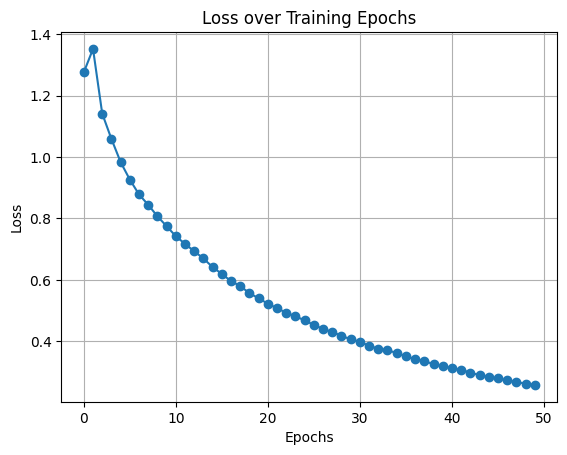

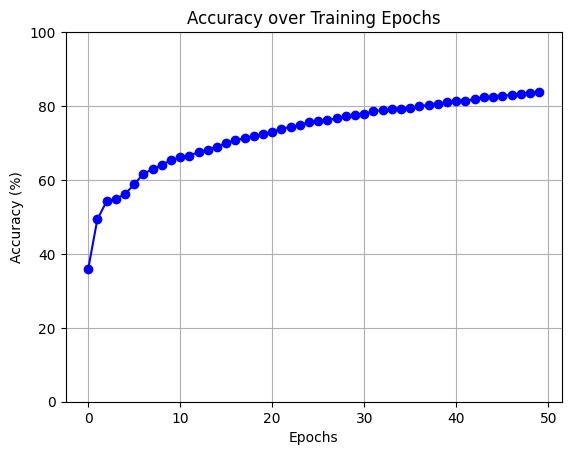

In [39]:
loss_values = [l.item() for l in metrics['loss']]
acc_values =  metrics['ACC']
plt.plot(loss_values, marker='o')
plt.title('Loss over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()
plt.plot(acc_values, marker='o', color='b')
plt.title('Accuracy over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # 设置 y 轴范围为 0 到 100
plt.grid()
plt.show()

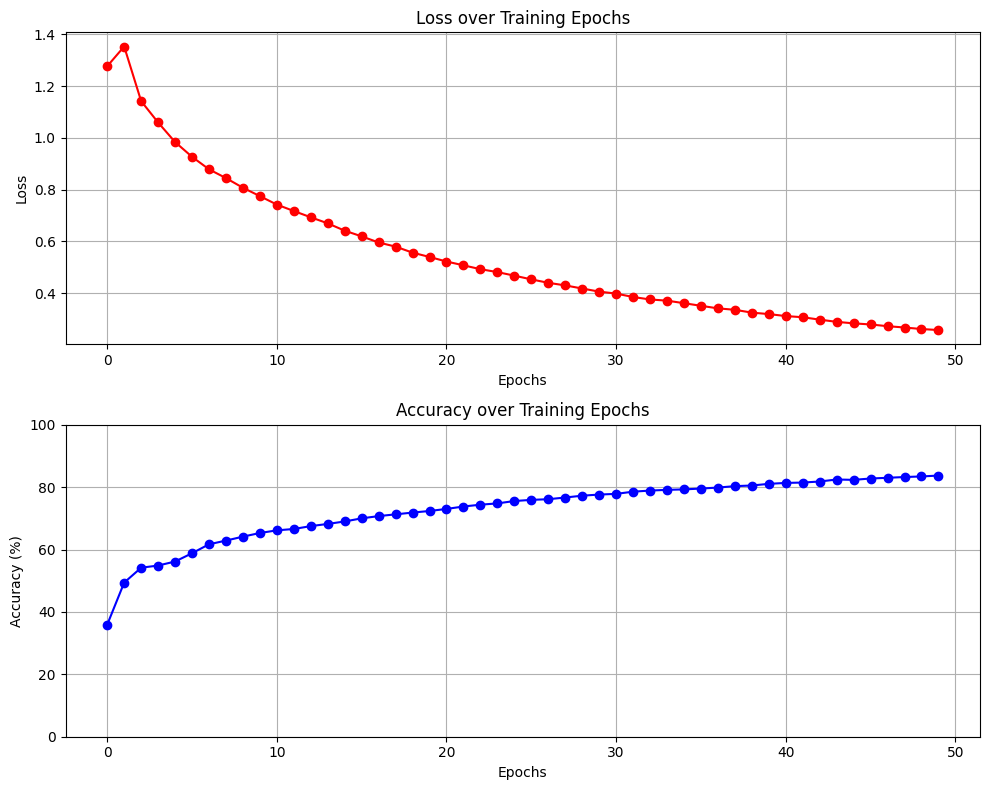

In [40]:
# 创建子图
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 绘制损失值
axs[0].plot(loss_values, marker='o', color='r')
axs[0].set_title('Loss over Training Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].grid()

# 绘制准确率
axs[1].plot(acc_values, marker='o', color='b')
axs[1].set_title('Accuracy over Training Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_ylim(0, 100)  # 设置 y 轴范围为 0 到 100
axs[1].grid()

# 调整布局
plt.tight_layout()

# 保存为 PDF 文件
plt.savefig('training_metrics.pdf', format='pdf')

# 显示图形
plt.show()

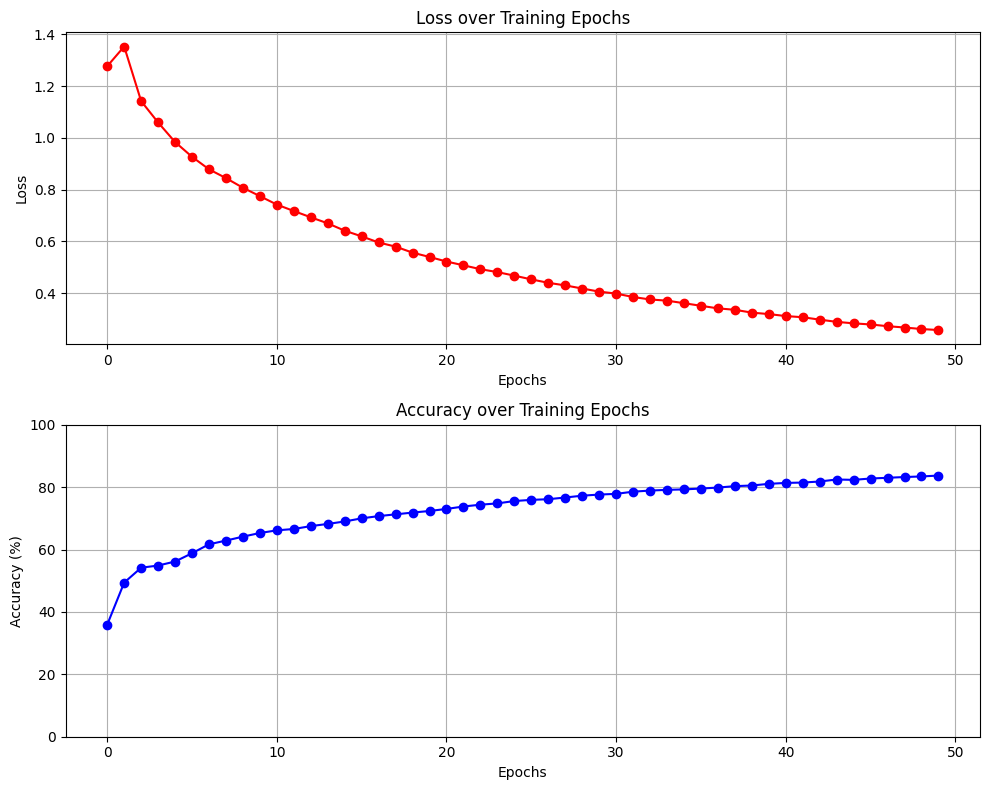

In [41]:
data = {
    'Epochs': list(range(1, len(acc_values) + 1)),
    'Accuracy': acc_values,
    'Loss': loss_values
}

df = pd.DataFrame(data)

# 保存为 CSV 文件
df.to_csv('training_metrics.csv', index=False)

# 创建子图
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 绘制损失值
axs[0].plot(loss_values, marker='o', color='r')
axs[0].set_title('Loss over Training Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].grid()

# 绘制准确率
axs[1].plot(acc_values, marker='o', color='b')
axs[1].set_title('Accuracy over Training Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_ylim(0, 100)  # 设置 y 轴范围为 0 到 100
axs[1].grid()

# 调整布局
plt.tight_layout()

# 保存为 PDF 文件
plt.savefig('training_metrics.pdf', format='pdf')

# 显示图形
plt.show()

In [35]:
metrics

{'ACC': [35.924528301886795,
  49.41509433962264,
  54.18867924528302,
  54.88679245283019,
  56.16981132075472,
  58.83018867924529,
  61.698113207547166,
  62.886792452830186,
  64.15094339622641,
  65.32075471698113,
  66.16981132075472,
  66.60377358490565,
  67.52830188679245,
  68.22641509433961,
  69.01886792452831,
  70.01886792452831,
  70.73584905660377,
  71.30188679245283,
  71.86792452830188,
  72.37735849056604,
  73.0377358490566,
  73.81132075471697,
  74.39622641509433,
  74.81132075471699,
  75.56603773584905,
  75.94339622641509,
  76.15094339622641,
  76.69811320754717,
  77.28301886792453,
  77.64150943396227,
  77.86792452830188,
  78.56603773584906,
  78.92452830188678,
  79.15094339622641,
  79.30188679245282,
  79.56603773584906,
  79.88679245283019,
  80.33962264150944,
  80.54716981132076,
  81.0754716981132,
  81.37735849056604,
  81.49056603773585,
  81.83018867924528,
  82.47169811320755,
  82.35849056603773,
  82.79245283018868,
  83.01886792452831,
  83.

In [72]:
import pickle



# 保存为 Pickle 文件
with open("metrics.pkl", "wb") as pickle_file:
    pickle.dump(metrics_3, pickle_file)
print(metrics_3)
print("字典已保存为 metrics.pkl")

{'precision': [0.64, 0.48, 0.53, 0.59, 0.55, 0.62, 0.6, 0.64, 0.65, 0.64, 0.64, 0.63, 0.63, 0.63, 0.62, 0.66, 0.66, 0.73, 0.77, 0.79, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.82, 0.82, 0.82, 0.82, 0.83, 0.83, 0.83, 0.84, 0.85, 0.85, 0.86, 0.86, 0.87, 0.88, 0.89, 0.89, 0.9, 0.9, 0.9, 0.9, 0.9, 0.91, 0.9, 0.91], 'f1_score': [0.64, 0.48, 0.53, 0.59, 0.55, 0.62, 0.6, 0.64, 0.65, 0.64, 0.64, 0.63, 0.63, 0.63, 0.62, 0.66, 0.66, 0.73, 0.77, 0.79, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.82, 0.82, 0.82, 0.82, 0.83, 0.83, 0.83, 0.84, 0.85, 0.85, 0.86, 0.86, 0.87, 0.88, 0.89, 0.89, 0.9, 0.9, 0.9, 0.9, 0.9, 0.91, 0.9, 0.91], 'recall': [0.64, 0.48, 0.53, 0.59, 0.55, 0.62, 0.6, 0.64, 0.65, 0.64, 0.64, 0.63, 0.63, 0.63, 0.62, 0.66, 0.66, 0.73, 0.77, 0.79, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.82, 0.82, 0.82, 0.82, 0.83, 0.83, 0.83, 0.84, 0.85, 0.85, 0.86, 0.86, 0.87, 0.88, 0.89, 0.89, 0.9, 0.9, 0.9, 0.9, 0.9, 0.91, 0.9, 0.91]}
字典已保存为 metrics.pkl


In [3]:
import pickle

# 使用二进制模式 ('rb') 打开文件
with open('metrics.pkl', 'rb') as file:
    metrics = pickle.load(file)

# 打印或处理读取的数据
print(metrics)

{'precision': [0.64, 0.48, 0.53, 0.59, 0.55, 0.62, 0.6, 0.64, 0.65, 0.64, 0.64, 0.63, 0.63, 0.63, 0.62, 0.66, 0.66, 0.73, 0.77, 0.79, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.82, 0.82, 0.82, 0.82, 0.83, 0.83, 0.83, 0.84, 0.85, 0.85, 0.86, 0.86, 0.87, 0.88, 0.89, 0.89, 0.9, 0.9, 0.9, 0.9, 0.9, 0.91, 0.9, 0.91], 'f1_score': [0.64, 0.48, 0.53, 0.59, 0.55, 0.62, 0.6, 0.64, 0.65, 0.64, 0.64, 0.63, 0.63, 0.63, 0.62, 0.66, 0.66, 0.73, 0.77, 0.79, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.82, 0.82, 0.82, 0.82, 0.83, 0.83, 0.83, 0.84, 0.85, 0.85, 0.86, 0.86, 0.87, 0.88, 0.89, 0.89, 0.9, 0.9, 0.9, 0.9, 0.9, 0.91, 0.9, 0.91], 'recall': [0.64, 0.48, 0.53, 0.59, 0.55, 0.62, 0.6, 0.64, 0.65, 0.64, 0.64, 0.63, 0.63, 0.63, 0.62, 0.66, 0.66, 0.73, 0.77, 0.79, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.82, 0.82, 0.82, 0.82, 0.83, 0.83, 0.83, 0.84, 0.85, 0.85, 0.86, 0.86, 0.87, 0.88, 0.89, 0.89, 0.9, 0.9, 0.9, 0.9, 0.9, 0.91, 0.9, 0.91]}


In [12]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# 使用二进制模式 ('rb') 打开文件
with open('metrics.pkl', 'rb') as file:
    metrics = pickle.load(file)

# 提取字典的键和值
keys = list(metrics.keys())
values = list(metrics.values())

# 创建一个 PDF 文件
with PdfPages('metrics_vertical.pdf') as pdf:
    plt.figure(figsize=(8, 5))
    
    # 创建表格数据，确保每个值在独立的行中
    table_data = list(zip(*[keys, values]))  # 转置，使其成为列
    
    # 创建表格
    plt.table(cellText=table_data, cellLoc='center', loc='center', colLabels=['Metric Name', 'Value'])
    
    # 设置标题
    plt.title('Metrics Values', fontsize=16)
    plt.axis('off')  # 关闭坐标轴
    
    pdf.savefig()  # 保存当前图形到 PDF
    plt.close()  # 关闭图形


In [13]:
metrics_3

{'precision': [0.6,
  0.45,
  0.5,
  0.54,
  0.48,
  0.58,
  0.59,
  0.62,
  0.62,
  0.62,
  0.66,
  0.68,
  0.68,
  0.7,
  0.7,
  0.75,
  0.77,
  0.77,
  0.76,
  0.77,
  0.77,
  0.77,
  0.77,
  0.77,
  0.77,
  0.77,
  0.77,
  0.77,
  0.77,
  0.77,
  0.78,
  0.79,
  0.79,
  0.8,
  0.8,
  0.8,
  0.8,
  0.81,
  0.81,
  0.81,
  0.81,
  0.81,
  0.83,
  0.83,
  0.84,
  0.84,
  0.84,
  0.85,
  0.85,
  0.85],
 'f1_score': [0.6,
  0.45,
  0.5,
  0.54,
  0.48,
  0.58,
  0.59,
  0.62,
  0.62,
  0.62,
  0.66,
  0.68,
  0.68,
  0.7,
  0.7,
  0.75,
  0.77,
  0.77,
  0.76,
  0.77,
  0.77,
  0.77,
  0.77,
  0.77,
  0.77,
  0.77,
  0.77,
  0.77,
  0.77,
  0.77,
  0.78,
  0.79,
  0.79,
  0.8,
  0.8,
  0.8,
  0.8,
  0.81,
  0.81,
  0.81,
  0.81,
  0.81,
  0.83,
  0.83,
  0.84,
  0.84,
  0.84,
  0.85,
  0.85,
  0.85],
 'recall': [0.6,
  0.45,
  0.5,
  0.54,
  0.48,
  0.58,
  0.59,
  0.62,
  0.62,
  0.62,
  0.66,
  0.68,
  0.68,
  0.7,
  0.7,
  0.75,
  0.77,
  0.77,
  0.76,
  0.77,
  0.77,
  0.77,
  0.77,

In [24]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def plot_metrics_separately_to_pdf(metrics, filename):
    # 创建一个新的 PDF 文件
    with PdfPages(filename) as pdf_pages:
        # 绘制 Precision
        plt.figure(figsize=(10, 5))
        plt.plot(metrics['precision'], label='Precision', marker='o', color='blue')
        plt.title('Precision Over Time')
        plt.xlabel('Index')
        plt.ylabel('Precision Score')
        plt.xticks(range(len(metrics['precision'])))  # 设置x轴刻度
        plt.legend()
        plt.grid()
        plt.tight_layout()
        pdf_pages.savefig()  # 保存当前图表到 PDF
        plt.close()

        # 绘制 F1 Score
        plt.figure(figsize=(10, 5))
        plt.plot(metrics['f1_score'], label='F1 Score', marker='s', color='green')
        plt.title('F1 Score Over Time')
        plt.xlabel('Index')
        plt.ylabel('F1 Score')
        plt.xticks(range(len(metrics['f1_score'])))  # 设置x轴刻度
        plt.legend()
        plt.grid()
        plt.tight_layout()
        pdf_pages.savefig()  # 保存当前图表到 PDF
        plt.close()

        # 绘制 Recall
        plt.figure(figsize=(10, 5))
        plt.plot(metrics['recall'], label='Recall', marker='^', color='red')
        plt.title('Recall Over Time')
        plt.xlabel('Index')
        plt.ylabel('Recall Score')
        plt.xticks(range(len(metrics['recall'])))  # 设置x轴刻度
        plt.legend()
        plt.grid()
        plt.tight_layout()
        pdf_pages.savefig()  # 保存当前图表到 PDF
        plt.close()

# 示例字典数据
metrics_data = metrics_3

plot_metrics_separately_to_pdf(metrics_data, "metrics_output_separate.pdf")


In [16]:
import pandas as pd

def save_dict_to_csv(data, filename):
    # 将字典转换为DataFrame
    df = pd.DataFrame(data)

    # 保存为CSV文件
    df.to_csv(filename, index=False)

# 保存为CSV文件
save_dict_to_csv(metrics_3, "output.csv")


In [22]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def plot_dicts_to_pdf(data, filename):
    # 创建一个 PDF 文件
    with PdfPages(filename) as pdf_pages:
        # 遍历字典中的每个索引
        for index, values in data.items():
            keys = list(values.keys())
            vals = list(values.values())

            # 创建一个新的图表
            plt.figure(figsize=(8, 4))
            plt.bar(keys, vals, color='skyblue')

            # 添加标题和标签
            plt.title(f'Data Visualization for {index}')
            plt.xlabel('Keys')
            plt.ylabel('Values')

            # 保存当前图表到 PDF
            pdf_pages.savefig()
            plt.close()

# 示例字典


plot_dicts_to_pdf(metrics_3, "output.pdf")


/tmp/ipykernel_9511/2319259599.py:6: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed in 3.10.
  with PdfPages(filename) as pdf_pages:


AttributeError: 'list' object has no attribute 'keys'

In [20]:
pip install PdfPages

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


[0.64, 0.48, 0.53, 0.59, 0.55, 0.62, 0.6, 0.64, 0.65, 0.64, 0.64, 0.63, 0.63, 0.63, 0.62, 0.66, 0.66, 0.73, 0.77, 0.79, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.82, 0.82, 0.82, 0.82, 0.83, 0.83, 0.83, 0.84, 0.85, 0.85, 0.86, 0.86, 0.87, 0.88, 0.89, 0.89, 0.9, 0.9, 0.9, 0.9, 0.9, 0.91, 0.9, 0.91]


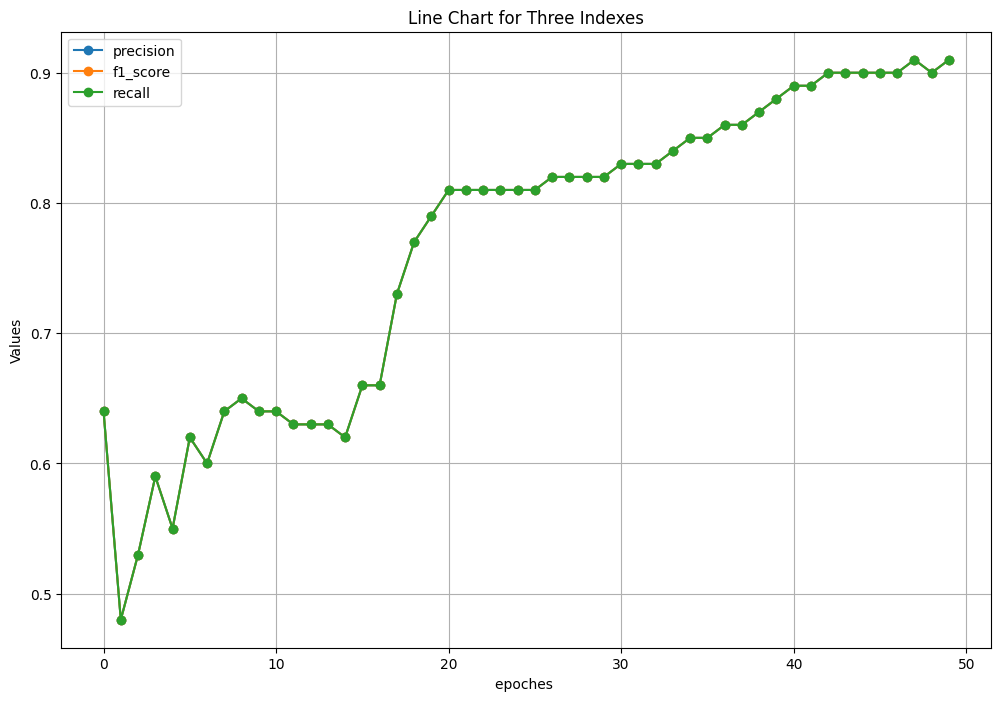

In [75]:
import matplotlib.pyplot as plt

# 绘制多个曲线图
plt.figure(figsize=(12, 8))  # 设置图形大小

# 为每个索引绘制曲线
print(metrics.get('precision'))
for index, values in metrics.items():
    plt.plot(values, label=index, marker='o', linestyle='-')

# 添加图例、标题和标签
plt.xlabel('epoches ')
plt.ylabel('Values')
plt.title('Line Chart for Three Indexes')
plt.legend(loc='best')
plt.grid(True)  # 添加网格线

# 显示图形
plt.show()


In [123]:
pip install pickle

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
Note: you may need to restart the kernel to use updated packages.


In [59]:
# metrics
for i in range(epoch):
    metrics["loss"][i]=metrics["loss"][i].item()

AttributeError: 'float' object has no attribute 'item'

In [60]:
metrics

{'ACC': [42.45283018867924,
  54.83018867924528,
  54.943396226415096,
  56.0188679245283,
  59.16981132075472,
  60.886792452830186,
  62.56603773584906,
  63.77358490566037,
  64.62264150943396,
  65.52830188679245,
  66.69811320754717,
  67.47169811320755,
  68.33962264150944,
  68.71698113207547,
  69.33962264150944,
  69.50943396226415,
  69.86792452830188,
  70.37735849056604,
  70.84905660377359,
  71.39622641509435,
  71.86792452830188,
  72.22641509433963,
  72.84905660377359,
  73.47169811320755,
  74.0188679245283,
  74.35849056603774,
  74.77358490566037,
  75.09433962264151,
  75.33962264150944,
  75.66037735849058,
  76.0377358490566,
  76.43396226415095,
  76.83018867924528,
  77.13207547169812,
  77.47169811320754,
  77.9245283018868,
  78.09433962264151,
  78.52830188679245,
  79.0377358490566,
  79.45283018867924,
  80.01886792452831,
  80.32075471698114,
  80.62264150943396,
  80.9245283018868,
  81.15094339622641,
  81.33962264150944,
  81.56603773584906,
  81.75471

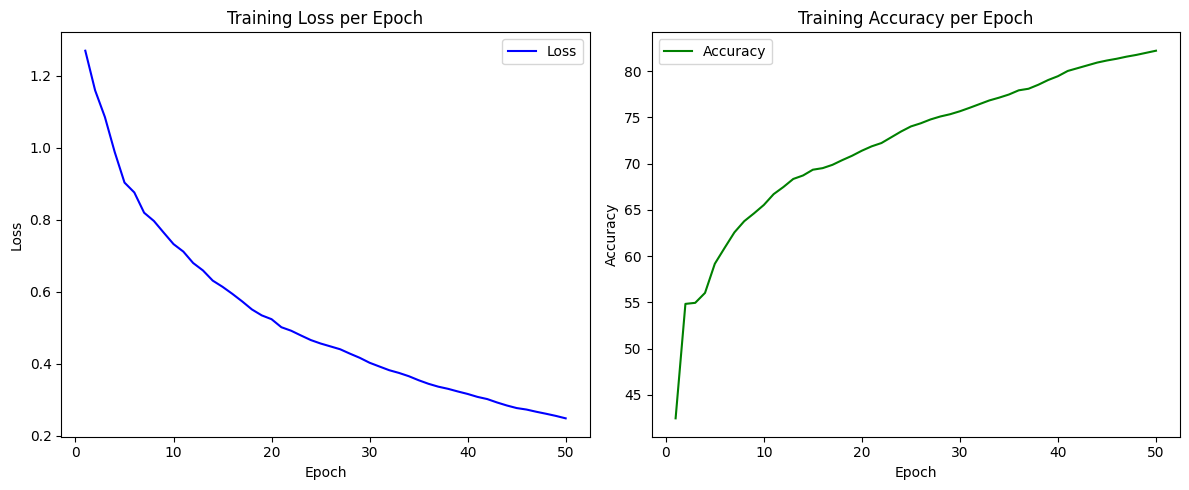

In [61]:
import matplotlib.pyplot as plt

# 获取 epochs 数量（假设 epochs 的数量与 ACC 和 loss 列表长度相同）
epochs = range(1, len(metrics["ACC"]) + 1)

# 创建图形
plt.figure(figsize=(12, 5))

# 绘制损失曲线
plt.subplot(1, 2, 1)  # 在一行中创建两个子图
plt.plot(epochs, metrics["loss"], 'b-', label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()

# 绘制精确度曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, metrics["ACC"], 'g-', label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy per Epoch")
plt.legend()

# 调整布局并显示图像
plt.tight_layout()
plt.show()


In [62]:
# 保存整个模型
torch.save(model.state_dict(), "best_text_cnn_model.pth")  # 只保存模型参数
torch.save(model, "text_cnn_full_model.pth")
# 保存模型的 state_dict（推荐做法）

torch.save(model.state_dict(), "text_cnn_model.pth")


In [63]:
# 加载整个模型
model = torch.load("text_cnn_full_model.pth")
model.to(device)
model.eval()



TextCNNModel(
  (block1): Block(
    (cnn): Conv2d(1, 2, kernel_size=(2, 100), stride=(1, 1))
    (act): ReLU()
    (mxp): MaxPool1d(kernel_size=511, stride=511, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Block(
    (cnn): Conv2d(1, 2, kernel_size=(3, 100), stride=(1, 1))
    (act): ReLU()
    (mxp): MaxPool1d(kernel_size=510, stride=510, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Block(
    (cnn): Conv2d(1, 2, kernel_size=(4, 100), stride=(1, 1))
    (act): ReLU()
    (mxp): MaxPool1d(kernel_size=509, stride=509, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Block(
    (cnn): Conv2d(1, 2, kernel_size=(5, 100), stride=(1, 1))
    (act): ReLU()
    (mxp): MaxPool1d(kernel_size=508, stride=508, padding=0, dilation=1, ceil_mode=False)
  )
  (emb_matrix): Embedding(1773, 100)
  (classifier): Linear(in_features=8, out_features=4, bias=True)
  (loss_fun): CrossEntropyLoss()
)

In [64]:
# 定义文本预处理函数，将输入句子转换为适合模型的张量格式
def preprocess_text(sentence, word_2_index, max_len, device):
    # 将句子中的每个词映射为词汇表中的索引值，若词不存在则映射为 <UNK> 的索引
    text_idx = [word_2_index.get(word, word_2_index["<UNK>"]) for word in sentence]
    
    # 将索引序列填充或截断到 max_len 长度
    # 如果长度不足 max_len，则在末尾补 0；如果超过 max_len，则截断
    text_idx = text_idx[:max_len] + [0] * max(0, max_len - len(text_idx))
    
    # 将索引列表转换为 PyTorch 张量，并添加两维度以适应模型输入要求
    # - 第一个 unsqueeze：为 batch 维度
    # - 第二个 unsqueeze：为通道维度（单通道）
    return torch.tensor(text_idx).unsqueeze(0).unsqueeze(0).to(device)

# 定义预测函数，用于对单条输入句子进行预测
def predict(model, sentence, word_2_index, max_len, device):
    # 调用预处理函数，将句子转换为适合模型输入的张量
    input_tensor = preprocess_text(sentence, word_2_index, max_len, device)
    
    # 使用 no_grad 禁用梯度计算，以提高推理速度和减少内存占用
    with torch.no_grad():
        # 将预处理后的输入张量传入模型，并获取模型的输出
        prediction = model(input_tensor)
        
        # 将模型的预测输出（张量）转换为整数标签
        predicted_label = prediction.item()
    return predicted_label
# 标签映射字典
label_map = {
    0: "湿热蕴结兼脾虚证",
    1: "湿热蕴结证",
    2: "脾虚气滞证",
    3: "其他"
}

# 使用示例
# 定义要预测的句子
sentence = "  一、病例特点: 患者1月前无明显诱因下自觉上腹胀痛，外院查体提示胰体尾占位。患者无明显自觉症状，无发热、腹痛、恶心呕吐，无皮肤巩膜黄染，无腹胀腹泻。为进一步治疗来我院。门诊以“胰腺肿瘤”收治入院。患者病来一般情况良好，神志清、精神可，大小便基本正常。二、拟诊讨论: (一)诊断:胰腺肿瘤 (二)诊断依据:1.患者，女，26岁2.因“上腹胀痛一月余”入院3.体检：ECOG：1，神志清，查体合作，全身浅表淋巴结未及肿大，皮肤巩膜无黄染，腹平软。右上腹深压痛阴性，无明显肌紧张、反跳痛。余腹部无明显压痛及反跳痛。肝肋下未及，剑突下未及，脾肋下未及。亦未扪及明显肿块。Murphy征阴性，移动性浊音阴性，肠鸣音3-5次/分4.辅助检查：CT:(中山医院，2015-10-21)诊断: 腹部CT增强扫描：胰尾囊性占位，考虑囊腺瘤可能，建议必要时结合MRI扫描。腹膜后未见明显肿大淋巴结。"

# 调用 predict 函数对句子进行预测，并输出预测的标签
predicted_label = predict(model, sentence, word_2_index, max_len, device)
print(f"Predicted label: {predicted_label}")
print(label_map.get(predicted_label))

Predicted label: 3
其他


1

Vocab size: 4762


5300it [00:00, 8436.68it/s]


Epoch 1, Loss: 1.262654080762336, Dev Accuracy: 0.47924528301886793, Dev F1 Score: 0.40963912270722047
Epoch 2, Loss: 1.1261344348365938, Dev Accuracy: 0.5188679245283019, Dev F1 Score: 0.45782577709068534
Epoch 3, Loss: 1.0015421072442328, Dev Accuracy: 0.5330188679245284, Dev F1 Score: 0.48465241148628035
Epoch 4, Loss: 0.9082643593376006, Dev Accuracy: 0.5754716981132075, Dev F1 Score: 0.5162914800909343
Epoch 5, Loss: 0.8712039068715656, Dev Accuracy: 0.5669811320754717, Dev F1 Score: 0.5119084511400728
Epoch 6, Loss: 0.8493487529419176, Dev Accuracy: 0.5792452830188679, Dev F1 Score: 0.49730015248514514
Epoch 7, Loss: 0.8330036542523447, Dev Accuracy: 0.5971698113207548, Dev F1 Score: 0.5542037485894105
Epoch 8, Loss: 0.8080524147754937, Dev Accuracy: 0.6009433962264151, Dev F1 Score: 0.5654265392675896
Epoch 9, Loss: 0.7897182863261831, Dev Accuracy: 0.6150943396226415, Dev F1 Score: 0.5609627318152429
Epoch 10, Loss: 0.7674265515864195, Dev Accuracy: 0.6075471698113207, Dev F1 S

ValueError: x and y must have same first dimension, but have shapes (10,) and (100,)

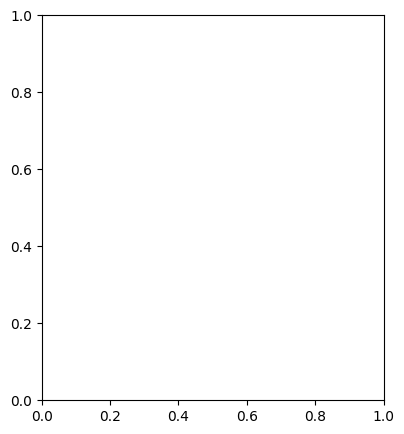

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pickle as pkl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# 数据集和词汇表路径
data_path = './data0924.txt'  # 数据集
vocab_path = './vocab.pkl'  # 词表

# 加载预训练的词嵌入
embedding_pretrained = torch.tensor(
    np.load('./embedding_Tencent.npz')["embeddings"].astype('float32')
)

# 数据加载和处理函数
def get_data(pad_size=512):
    tokenizer = lambda x: [y for y in x]  # 字级别分词器
    vocab = pkl.load(open(vocab_path, 'rb'))
    print(f"Vocab size: {len(vocab)}")

    train, dev, test = load_dataset(data_path, pad_size, tokenizer, vocab)
    return vocab, train, dev, test


def load_dataset(path, pad_size, tokenizer, vocab):
    '''
    将路径文本文件分词并转为三元组返回
    :param path: 文件路径
    :param pad_size: 每个序列的大小
    :param tokenizer: 分词函数
    :param vocab: 词汇表
    :return: 三个数据集：训练集、验证集和测试集
    '''
    contents = []
    with open(path, 'r', encoding='gbk') as f:
        for line in tqdm(f):
            lin = line.strip()
            if not lin:
                continue
            label, content = lin.split('\t####\t')
            words_line = []
            token = tokenizer(content)
            seq_len = len(token)
            if pad_size:
                if len(token) < pad_size:
                    token.extend([vocab.get("<PAD>")] * (pad_size - len(token)))
                else:
                    token = token[:pad_size]
                    seq_len = pad_size
            for word in token:
                words_line.append(vocab.get(word, vocab.get("<UNK>")))
            contents.append((words_line, int(label)))

    train, X_t = train_test_split(contents, test_size=0.4, random_state=42)
    dev, test = train_test_split(X_t, test_size=0.5, random_state=42)
    return train, dev, test


# 数据集类
class TextDataset(Dataset):
    def __init__(self, data):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.x = torch.LongTensor([x[0] for x in data]).to(self.device)
        self.y = torch.LongTensor([x[1] for x in data]).to(self.device)

    def __getitem__(self, index):
        text = self.x[index]
        label = self.y[index]
        return text, label

    def __len__(self):
        return len(self.x)


# 模块化卷积块
class Block(nn.Module):
    def __init__(self, kernel_s, embedding_num, max_len, hidden_num):
        super().__init__()
        self.cnn = nn.Conv2d(in_channels=1, out_channels=hidden_num, kernel_size=(kernel_s, embedding_num))
        self.act = nn.ReLU()
        self.mxp = nn.MaxPool1d(kernel_size=(max_len - kernel_s + 1))

    def forward(self, batch_emb):
        c = self.cnn(batch_emb)
        a = self.act(c)
        a = a.squeeze(dim=-1)
        m = self.mxp(a)
        m = m.squeeze(dim=-1)
        return m


# TextCNN 模型定义
class TextCNNModel(nn.Module):
    def __init__(self, emb_matrix, max_len, class_num, hidden_num):
        super().__init__()
        self.emb_num = emb_matrix.weight.shape[1]
        self.block1 = Block(2, self.emb_num, max_len, hidden_num)
        self.block2 = Block(3, self.emb_num, max_len, hidden_num)
        self.block3 = Block(4, self.emb_num, max_len, hidden_num)
        self.block4 = Block(5, self.emb_num, max_len, hidden_num)
        self.emb_matrix = emb_matrix
        self.classifier = nn.Linear(hidden_num * 4, class_num)
        self.loss_fun = nn.CrossEntropyLoss()

    def forward(self, batch_idx, batch_label=None):
        batch_emb = self.emb_matrix(batch_idx)
        batch_emb = batch_emb.unsqueeze(1)  # 添加通道维度
        b1_result = self.block1(batch_emb)
        b2_result = self.block2(batch_emb)
        b3_result = self.block3(batch_emb)
        b4_result = self.block4(batch_emb)
        feature = torch.cat([b1_result, b2_result, b3_result, b4_result], dim=1)
        pre = self.classifier(feature)
        if batch_label is not None:
            loss = self.loss_fun(pre, batch_label)
            return loss, pre
        else:
            return pre


# 主程序
if __name__ == "__main__":
    # 假设训练数据和模型参数已知
    pad_size = 512
    class_num = 4  # 假设有 4 个分类
    hidden_num = 2
    batch_size = 16  # 减小 batch size 以减少显存占用
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 1. 获取数据集
    vocab, train_data, dev_data, test_data = get_data(pad_size)

    # 2. 构建 DataLoader
    train_dataset = TextDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_dataset = TextDataset(dev_data)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

    # 3. 初始化模型
    emb_matrix = nn.Embedding(len(vocab), embedding_pretrained.shape[1])
    emb_matrix.weight.data.copy_(embedding_pretrained)
    emb_matrix.weight.requires_grad = False
    model = TextCNNModel(emb_matrix, pad_size, class_num, hidden_num).to(device)

    # 4. 定义优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 5. 训练模型并记录指标
    model.train()
    train_losses = []
    dev_accuracies = []
    dev_f1_scores = []

    for epoch in range(100):  # 假设训练 10 个 epoch
        total_loss = 0.0
        model.train()
        for texts, labels in train_loader:
            optimizer.zero_grad()
            texts, labels = texts.to(device), labels.to(device)  # 确保数据在正确的设备上
            loss, _ = model(texts, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # 验证模型
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for texts, labels in dev_loader:
                texts, labels = texts.to(device), labels.to(device)  # 确保数据在正确的设备上
                outputs = model(texts)
                preds = torch.argmax(outputs, dim=-1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        dev_accuracies.append(acc)
        dev_f1_scores.append(f1)

        print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Dev Accuracy: {acc}, Dev F1 Score: {f1}")

    # 绘制 Loss、Accuracy 和 F1-Score 的图像
    epochs = range(1, 11)
    plt.figure(figsize=(15, 5))

    # Loss 图像
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Accuracy 图像
    plt.subplot(1, 3, 2)
    plt.plot(epochs, dev_accuracies, 'b', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # F1-Score 图像
    plt.subplot(1, 3, 3)
    plt.plot(epochs, dev_f1_scores, 'g', label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


Vocab size: 4762


5300it [00:00, 7913.02it/s]


Epoch 1, Loss: 1.305177165635267, Dev Accuracy: 0.49245283018867925, Dev F1 Score: 0.4484406702512484
Epoch 2, Loss: 1.0598189117920458, Dev Accuracy: 0.5735849056603773, Dev F1 Score: 0.5175415942136594
Epoch 3, Loss: 0.9459762618170312, Dev Accuracy: 0.6122641509433963, Dev F1 Score: 0.5957231822740265
Epoch 4, Loss: 0.9030145504067292, Dev Accuracy: 0.6160377358490566, Dev F1 Score: 0.6027545861452055
Epoch 5, Loss: 0.8634105862385064, Dev Accuracy: 0.6235849056603774, Dev F1 Score: 0.6129684143811642
Epoch 6, Loss: 0.8336952512887255, Dev Accuracy: 0.630188679245283, Dev F1 Score: 0.6190894036461353
Epoch 7, Loss: 0.8076569674602107, Dev Accuracy: 0.6452830188679245, Dev F1 Score: 0.6322649143539878
Epoch 8, Loss: 0.7867298803137774, Dev Accuracy: 0.6433962264150943, Dev F1 Score: 0.6289940711086789
Epoch 9, Loss: 0.7721858812336946, Dev Accuracy: 0.6556603773584906, Dev F1 Score: 0.6530756087100511
Epoch 10, Loss: 0.751065391391965, Dev Accuracy: 0.6632075471698113, Dev F1 Score: 

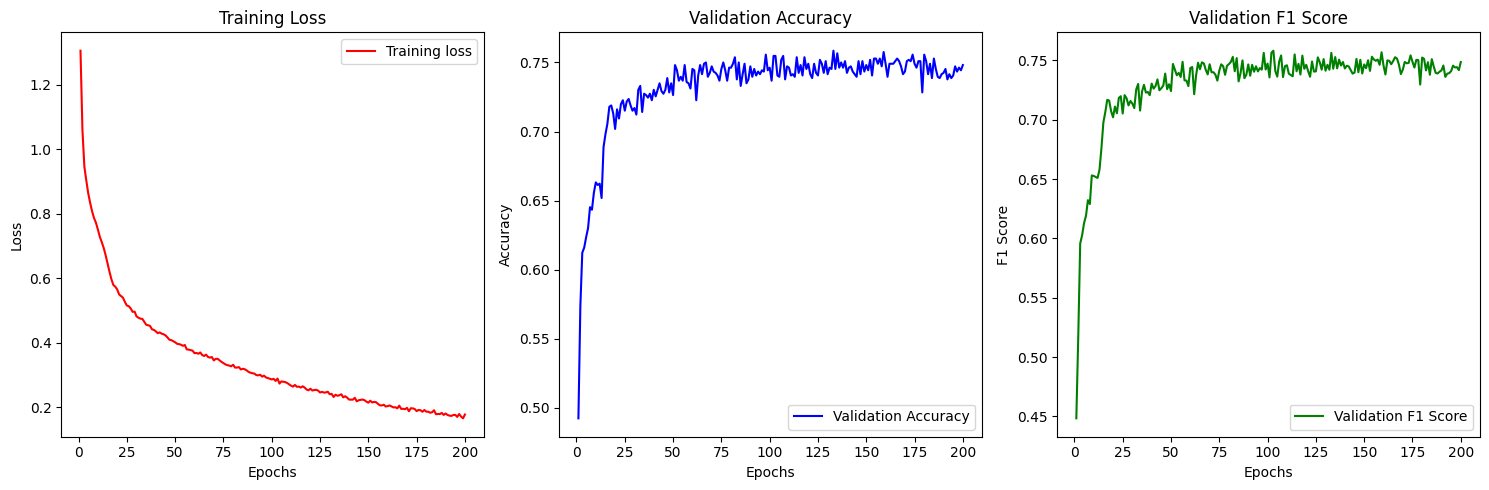

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pickle as pkl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# 数据集和词汇表路径
data_path = './data0924.txt'  # 数据集
vocab_path = './vocab.pkl'  # 词表

# 加载预训练的词嵌入
embedding_pretrained = torch.tensor(
    np.load('./embedding_Tencent.npz')["embeddings"].astype('float32')
)

# 数据加载和处理函数
def get_data(pad_size=512):
    tokenizer = lambda x: [y for y in x]  # 字级别分词器
    vocab = pkl.load(open(vocab_path, 'rb'))
    print(f"Vocab size: {len(vocab)}")

    train, dev, test = load_dataset(data_path, pad_size, tokenizer, vocab)
    return vocab, train, dev, test


def load_dataset(path, pad_size, tokenizer, vocab):
    '''
    将路径文本文件分词并转为三元组返回
    :param path: 文件路径
    :param pad_size: 每个序列的大小
    :param tokenizer: 分词函数
    :param vocab: 词汇表
    :return: 三个数据集：训练集、验证集和测试集
    '''
    contents = []
    with open(path, 'r', encoding='gbk') as f:
        for line in tqdm(f):
            lin = line.strip()
            if not lin:
                continue
            label, content = lin.split('\t####\t')
            words_line = []
            token = tokenizer(content)
            seq_len = len(token)
            if pad_size:
                if len(token) < pad_size:
                    token.extend([vocab.get("<PAD>")] * (pad_size - len(token)))
                else:
                    token = token[:pad_size]
                    seq_len = pad_size
            for word in token:
                words_line.append(vocab.get(word, vocab.get("<UNK>")))
            contents.append((words_line, int(label)))

    train, X_t = train_test_split(contents, test_size=0.4, random_state=42)
    dev, test = train_test_split(X_t, test_size=0.5, random_state=42)
    return train, dev, test


# 数据集类
class TextDataset(Dataset):
    def __init__(self, data):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.x = torch.LongTensor([x[0] for x in data]).to(self.device)
        self.y = torch.LongTensor([x[1] for x in data]).to(self.device)

    def __getitem__(self, index):
        text = self.x[index]
        label = self.y[index]
        return text, label

    def __len__(self):
        return len(self.x)


# 模块化卷积块
class Block(nn.Module):
    def __init__(self, kernel_s, embedding_num, max_len, hidden_num):
        super().__init__()
        self.cnn = nn.Conv2d(in_channels=1, out_channels=hidden_num, kernel_size=(kernel_s, embedding_num))
        self.act = nn.ReLU()
        self.mxp = nn.MaxPool1d(kernel_size=(max_len - kernel_s + 1))

    def forward(self, batch_emb):
        c = self.cnn(batch_emb)
        a = self.act(c)
        a = a.squeeze(dim=-1)
        m = self.mxp(a)
        m = m.squeeze(dim=-1)
        return m


# TextCNN 模型定义
class TextCNNModel(nn.Module):
    def __init__(self, emb_matrix, max_len, class_num, hidden_num):
        super().__init__()
        self.emb_num = emb_matrix.weight.shape[1]
        self.block1 = Block(2, self.emb_num, max_len, hidden_num)
        self.block2 = Block(3, self.emb_num, max_len, hidden_num)
        self.block3 = Block(4, self.emb_num, max_len, hidden_num)
        self.block4 = Block(5, self.emb_num, max_len, hidden_num)
        self.emb_matrix = emb_matrix
        self.classifier = nn.Linear(hidden_num * 4, class_num)
        self.loss_fun = nn.CrossEntropyLoss()

    def forward(self, batch_idx, batch_label=None):
        batch_emb = self.emb_matrix(batch_idx)
        batch_emb = batch_emb.unsqueeze(1)  # 添加通道维度
        b1_result = self.block1(batch_emb)
        b2_result = self.block2(batch_emb)
        b3_result = self.block3(batch_emb)
        b4_result = self.block4(batch_emb)
        feature = torch.cat([b1_result, b2_result, b3_result, b4_result], dim=1)
        pre = self.classifier(feature)
        if batch_label is not None:
            loss = self.loss_fun(pre, batch_label)
            return loss, pre
        else:
            return pre


# 主程序
if __name__ == "__main__":
    # 假设训练数据和模型参数已知
    pad_size = 512
    class_num = 4  # 假设有 4 个分类
    hidden_num = 2
    batch_size = 16  # 减小 batch size 以减少显存占用
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 1. 获取数据集
    vocab, train_data, dev_data, test_data = get_data(pad_size)

    # 2. 构建 DataLoader
    train_dataset = TextDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_dataset = TextDataset(dev_data)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

    # 3. 初始化模型
    emb_matrix = nn.Embedding(len(vocab), embedding_pretrained.shape[1])
    emb_matrix.weight.data.copy_(embedding_pretrained)
    emb_matrix.weight.requires_grad = False
    model = TextCNNModel(emb_matrix, pad_size, class_num, hidden_num).to(device)

    # 4. 定义优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 5. 训练模型并记录指标
    model.train()
    train_losses = []
    dev_accuracies = []
    dev_f1_scores = []

    for epoch in range(200):  # 假设训练 10 个 epoch
        total_loss = 0.0
        model.train()
        for texts, labels in train_loader:
            optimizer.zero_grad()
            texts, labels = texts.to(device), labels.to(device)  # 确保数据在正确的设备上
            loss, _ = model(texts, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # 验证模型
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for texts, labels in dev_loader:
                texts, labels = texts.to(device), labels.to(device)  # 确保数据在正确的设备上
                outputs = model(texts)
                preds = torch.argmax(outputs, dim=-1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        dev_accuracies.append(acc)
        dev_f1_scores.append(f1)

        print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Dev Accuracy: {acc}, Dev F1 Score: {f1}")

    # 绘制 Loss、Accuracy 和 F1-Score 的图像
    epochs = range(1, 201)
    plt.figure(figsize=(15, 5))

    # Loss 图像
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Accuracy 图像
    plt.subplot(1, 3, 2)
    plt.plot(epochs, dev_accuracies, 'b', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # F1-Score 图像
    plt.subplot(1, 3, 3)
    plt.plot(epochs, dev_f1_scores, 'g', label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pickle as pkl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# 数据集和词汇表路径
data_path = './data0924.txt'  # 数据集
vocab_path = './vocab.pkl'  # 词表

# 加载预训练的词嵌入
embedding_pretrained = torch.tensor(
    np.load('./embedding_Tencent.npz')["embeddings"].astype('float32')
)

# 数据加载和处理函数
def get_data(pad_size=512):
    tokenizer = lambda x: [y for y in x]  # 字级别分词器
    vocab = pkl.load(open(vocab_path, 'rb'))
    print(f"Vocab size: {len(vocab)}")

    train, dev, test = load_dataset(data_path, pad_size, tokenizer, vocab)
    return vocab, train, dev, test


def load_dataset(path, pad_size, tokenizer, vocab):
    '''
    将路径文本文件分词并转为三元组返回
    :param path: 文件路径
    :param pad_size: 每个序列的大小
    :param tokenizer: 分词函数
    :param vocab: 词汇表
    :return: 三个数据集：训练集、验证集和测试集
    '''
    contents = []
    with open(path, 'r', encoding='gbk') as f:
        for line in tqdm(f):
            lin = line.strip()
            if not lin:
                continue
            label, content = lin.split('\t####\t')
            words_line = []
            token = tokenizer(content)
            seq_len = len(token)
            if pad_size:
                if len(token) < pad_size:
                    token.extend([vocab.get("<PAD>")] * (pad_size - len(token)))
                else:
                    token = token[:pad_size]
                    seq_len = pad_size
            for word in token:
                words_line.append(vocab.get(word, vocab.get("<UNK>")))
            contents.append((words_line, int(label)))

    train, X_t = train_test_split(contents, test_size=0.4, random_state=42)
    dev, test = train_test_split(X_t, test_size=0.5, random_state=42)
    return train, dev, test


# 数据集类
class TextDataset(Dataset):
    def __init__(self, data):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.x = torch.LongTensor([x[0] for x in data]).to(self.device)
        self.y = torch.LongTensor([x[1] for x in data]).to(self.device)

    def __getitem__(self, index):
        text = self.x[index]
        label = self.y[index]
        return text, label

    def __len__(self):
        return len(self.x)


# 模块化卷积块
class Block(nn.Module):
    def __init__(self, kernel_s, embedding_num, max_len, hidden_num):
        super().__init__()
        self.cnn = nn.Conv2d(in_channels=1, out_channels=hidden_num, kernel_size=(kernel_s, embedding_num))
        self.act = nn.ReLU()
        self.mxp = nn.MaxPool1d(kernel_size=(max_len - kernel_s + 1))

    def forward(self, batch_emb):
        c = self.cnn(batch_emb)
        a = self.act(c)
        a = a.squeeze(dim=-1)
        m = self.mxp(a)
        m = m.squeeze(dim=-1)
        return m


# TextCNN 模型定义
class TextCNNModel(nn.Module):
    def __init__(self, emb_matrix, max_len, class_num, hidden_num):
        super().__init__()
        self.emb_num = emb_matrix.weight.shape[1]
        self.block1 = Block(2, self.emb_num, max_len, hidden_num)
        self.block2 = Block(3, self.emb_num, max_len, hidden_num)
        self.block3 = Block(4, self.emb_num, max_len, hidden_num)
        self.block4 = Block(5, self.emb_num, max_len, hidden_num)
        self.emb_matrix = emb_matrix
        self.classifier = nn.Linear(hidden_num * 4, class_num)
        self.loss_fun = nn.CrossEntropyLoss()

    def forward(self, batch_idx, batch_label=None):
        batch_emb = self.emb_matrix(batch_idx)
        batch_emb = batch_emb.unsqueeze(1)  # 添加通道维度
        b1_result = self.block1(batch_emb)
        b2_result = self.block2(batch_emb)
        b3_result = self.block3(batch_emb)
        b4_result = self.block4(batch_emb)
        feature = torch.cat([b1_result, b2_result, b3_result, b4_result], dim=1)
        pre = self.classifier(feature)
        if batch_label is not None:
            loss = self.loss_fun(pre, batch_label)
            return loss, pre
        else:
            return pre


# 主程序
if __name__ == "__main__":
    # 假设训练数据和模型参数已知
    pad_size = 512
    class_num = 4  # 假设有 4 个分类
    hidden_num = 2
    batch_size = 16  # 减小 batch size 以减少显存占用
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 1. 获取数据集
    vocab, train_data, dev_data, test_data = get_data(pad_size)

    # 2. 构建 DataLoader
    train_dataset = TextDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_dataset = TextDataset(dev_data)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

    # 3. 初始化模型
    emb_matrix = nn.Embedding(len(vocab), embedding_pretrained.shape[1])
    emb_matrix.weight.data.copy_(embedding_pretrained)
    emb_matrix.weight.requires_grad = False
    model = TextCNNModel(emb_matrix, pad_size, class_num, hidden_num).to(device)

    # 4. 定义优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 5. 训练模型并记录指标
    model.train()
    train_losses = []
train_accuracies = []
dev_losses = []
    dev_accuracies = []
    dev_f1_scores = []

    for epoch in range(200):
        total_loss = 0.0
        total_dev_loss = 0.0
        model.train()
        for texts, labels in train_loader:
            optimizer.zero_grad()
            texts, labels = texts.to(device), labels.to(device)  # 确保数据在正确的设备上
            loss, outputs = model(texts, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=-1)
            correct_preds = (preds == labels).sum().item()
            train_accuracies.append(correct_preds / len(labels))
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # 验证模型
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for texts, labels in dev_loader:
                texts, labels = texts.to(device), labels.to(device)  # 确保数据在正确的设备上
                loss, outputs = model(texts, labels)
                total_dev_loss += loss.item()
                preds = torch.argmax(outputs, dim=-1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_dev_loss = total_dev_loss / len(dev_loader)
        dev_losses.append(avg_dev_loss)
        dev_accuracies.append(acc)
        dev_f1_scores.append(f1)

        print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Dev Accuracy: {acc}, Dev F1 Score: {f1}")

    # 绘制 Loss、Accuracy 和 F1-Score 的图像
    # Training Accuracy 图像
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 5, 1)
    plt.plot(epochs, train_accuracies, 'c', label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()
    # Validation Loss 图像
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 5, 2)
    plt.plot(epochs, dev_losses, 'm', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()
    epochs = range(1, 201)
    plt.figure(figsize=(25, 5))

    # Loss 图像
    plt.subplot(1, 5, 3)
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Accuracy 图像
    plt.subplot(1, 5, 4)
    plt.plot(epochs, dev_accuracies, 'b', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # F1-Score 图像
    plt.subplot(1, 5, 5)
    plt.plot(epochs, dev_f1_scores, 'g', label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


IndentationError: unexpected indent (3771131190.py, line 159)

In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pickle as pkl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# 数据集和词汇表路径
data_path = './data0924.txt'  # 数据集
vocab_path = './vocab.pkl'  # 词表

# 加载预训练的词嵌入
embedding_pretrained = torch.tensor(
    np.load('./embedding_Tencent.npz')["embeddings"].astype('float32')
)

# 数据加载和处理函数
def get_data(pad_size=512):
    tokenizer = lambda x: [y for y in x]  # 字级别分词器
    vocab = pkl.load(open(vocab_path, 'rb'))
    print(f"Vocab size: {len(vocab)}")

    train, dev, test = load_dataset(data_path, pad_size, tokenizer, vocab)
    return vocab, train, dev, test


def load_dataset(path, pad_size, tokenizer, vocab):
    '''
    将路径文本文件分词并转为三元组返回
    :param path: 文件路径
    :param pad_size: 每个序列的大小
    :param tokenizer: 分词函数
    :param vocab: 词汇表
    :return: 三个数据集：训练集、验证集和测试集
    '''
    contents = []
    with open(path, 'r', encoding='gbk') as f:
        for line in tqdm(f):
            lin = line.strip()
            if not lin:
                continue
            label, content = lin.split('\t####\t')
            words_line = []
            token = tokenizer(content)
            seq_len = len(token)
            if pad_size:
                if len(token) < pad_size:
                    token.extend([vocab.get("<PAD>")] * (pad_size - len(token)))
                else:
                    token = token[:pad_size]
                    seq_len = pad_size
            for word in token:
                words_line.append(vocab.get(word, vocab.get("<UNK>")))
            contents.append((words_line, int(label)))

    train, X_t = train_test_split(contents, test_size=0.4, random_state=42)
    dev, test = train_test_split(X_t, test_size=0.5, random_state=42)
    return train, dev, test


# 数据集类
class TextDataset(Dataset):
    def __init__(self, data):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.x = torch.LongTensor([x[0] for x in data]).to(self.device)
        self.y = torch.LongTensor([x[1] for x in data]).to(self.device)

    def __getitem__(self, index):
        text = self.x[index]
        label = self.y[index]
        return text, label

    def __len__(self):
        return len(self.x)


# 模块化卷积块
class Block(nn.Module):
    def __init__(self, kernel_s, embedding_num, max_len, hidden_num):
        super().__init__()
        self.cnn = nn.Conv2d(in_channels=1, out_channels=hidden_num, kernel_size=(kernel_s, embedding_num))
        self.act = nn.ReLU()
        self.mxp = nn.MaxPool1d(kernel_size=(max_len - kernel_s + 1))

    def forward(self, batch_emb):
        c = self.cnn(batch_emb)
        a = self.act(c)
        a = a.squeeze(dim=-1)
        m = self.mxp(a)
        m = m.squeeze(dim=-1)
        return m


# TextCNN 模型定义
class TextCNNModel(nn.Module):
    def __init__(self, emb_matrix, max_len, class_num, hidden_num):
        super().__init__()
        self.emb_num = emb_matrix.weight.shape[1]
        self.block1 = Block(2, self.emb_num, max_len, hidden_num)
        self.block2 = Block(3, self.emb_num, max_len, hidden_num)
        self.block3 = Block(4, self.emb_num, max_len, hidden_num)
        self.block4 = Block(5, self.emb_num, max_len, hidden_num)
        self.emb_matrix = emb_matrix
        self.classifier = nn.Linear(hidden_num * 4, class_num)
        self.loss_fun = nn.CrossEntropyLoss()

    def forward(self, batch_idx, batch_label=None):
        batch_emb = self.emb_matrix(batch_idx)
        batch_emb = batch_emb.unsqueeze(1)  # 添加通道维度
        b1_result = self.block1(batch_emb)
        b2_result = self.block2(batch_emb)
        b3_result = self.block3(batch_emb)
        b4_result = self.block4(batch_emb)
        feature = torch.cat([b1_result, b2_result, b3_result, b4_result], dim=1)
        pre = self.classifier(feature)
        if batch_label is not None:
            loss = self.loss_fun(pre, batch_label)
            return loss, pre
        else:
            return pre


# 主程序
if __name__ == "__main__":
    # 假设训练数据和模型参数已知
    pad_size = 512
    class_num = 4  # 假设有 4 个分类
    hidden_num = 2
    batch_size = 16  # 减小 batch size 以减少显存占用
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 1. 获取数据集
    vocab, train_data, dev_data, test_data = get_data(pad_size)

    # 2. 构建 DataLoader
    train_dataset = TextDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_dataset = TextDataset(dev_data)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

    # 3. 初始化模型
    emb_matrix = nn.Embedding(len(vocab), embedding_pretrained.shape[1])
    emb_matrix.weight.data.copy_(embedding_pretrained)
    emb_matrix.weight.requires_grad = False
    model = TextCNNModel(emb_matrix, pad_size, class_num, hidden_num).to(device)

    # 4. 定义优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 5. 训练模型并记录指标
    model.train()
    train_losses = []
train_accuracies = []
dev_losses = []
    dev_accuracies = []
    dev_f1_scores = []

    for epoch in range(200):
        total_loss = 0.0
        total_dev_loss = 0.0
        model.train()
        for texts, labels in train_loader:
            optimizer.zero_grad()
            texts, labels = texts.to(device), labels.to(device)  # 确保数据在正确的设备上
            loss, outputs = model(texts, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=-1)
            correct_preds = (preds == labels).sum().item()
            train_accuracies.append(correct_preds / len(labels))
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # 验证模型
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for texts, labels in dev_loader:
                texts, labels = texts.to(device), labels.to(device)  # 确保数据在正确的设备上
                loss, outputs = model(texts, labels)
                total_dev_loss += loss.item()
                preds = torch.argmax(outputs, dim=-1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_dev_loss = total_dev_loss / len(dev_loader)
        dev_losses.append(avg_dev_loss)
        dev_accuracies.append(acc)
        dev_f1_scores.append(f1)

        print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Dev Accuracy: {acc}, Dev F1 Score: {f1}")

    # 绘制 Loss、Accuracy 和 F1-Score 的图像
    # Training Accuracy 图像
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 5, 1)
    plt.plot(epochs, train_accuracies, 'c', label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()
    # Validation Loss 图像
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 5, 2)
    plt.plot(epochs, dev_losses, 'm', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()
    epochs = range(1, 201)
    plt.figure(figsize=(25, 5))

    # Loss 图像
    plt.subplot(1, 5, 3)
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Accuracy 图像
    plt.subplot(1, 5, 4)
    plt.plot(epochs, dev_accuracies, 'b', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # F1-Score 图像
    plt.subplot(1, 5, 5)
    plt.plot(epochs, dev_f1_scores, 'g', label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


IndentationError: unexpected indent (3771131190.py, line 159)

In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pickle as pkl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# 数据集和词汇表路径
data_path = './data0924.txt'  # 数据集
vocab_path = './vocab.pkl'  # 词表

# 加载预训练的词嵌入
embedding_pretrained = torch.tensor(
    np.load('./embedding_Tencent.npz')["embeddings"].astype('float32')
)

# 数据加载和处理函数
def get_data(pad_size=512):
    tokenizer = lambda x: [y for y in x]  # 字级别分词器
    vocab = pkl.load(open(vocab_path, 'rb'))
    print(f"Vocab size: {len(vocab)}")

    train, dev, test = load_dataset(data_path, pad_size, tokenizer, vocab)
    return vocab, train, dev, test


def load_dataset(path, pad_size, tokenizer, vocab):
    '''
    将路径文本文件分词并转为三元组返回
    :param path: 文件路径
    :param pad_size: 每个序列的大小
    :param tokenizer: 分词函数
    :param vocab: 词汇表
    :return: 三个数据集：训练集、验证集和测试集
    '''
    contents = []
    with open(path, 'r', encoding='gbk') as f:
        for line in tqdm(f):
            lin = line.strip()
            if not lin:
                continue
            label, content = lin.split('\t####\t')
            words_line = []
            token = tokenizer(content)
            seq_len = len(token)
            if pad_size:
                if len(token) < pad_size:
                    token.extend([vocab.get("<PAD>")] * (pad_size - len(token)))
                else:
                    token = token[:pad_size]
                    seq_len = pad_size
            for word in token:
                words_line.append(vocab.get(word, vocab.get("<UNK>")))
            contents.append((words_line, int(label)))

    train, X_t = train_test_split(contents, test_size=0.4, random_state=42)
    dev, test = train_test_split(X_t, test_size=0.5, random_state=42)
    return train, dev, test


# 数据集类
class TextDataset(Dataset):
    def __init__(self, data):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.x = torch.LongTensor([x[0] for x in data]).to(self.device)
        self.y = torch.LongTensor([x[1] for x in data]).to(self.device)

    def __getitem__(self, index):
        text = self.x[index]
        label = self.y[index]
        return text, label

    def __len__(self):
        return len(self.x)


# 模块化卷积块
class Block(nn.Module):
    def __init__(self, kernel_s, embedding_num, max_len, hidden_num):
        super().__init__()
        self.cnn = nn.Conv2d(in_channels=1, out_channels=hidden_num, kernel_size=(kernel_s, embedding_num))
        self.act = nn.ReLU()
        self.mxp = nn.MaxPool1d(kernel_size=(max_len - kernel_s + 1))

    def forward(self, batch_emb):
        c = self.cnn(batch_emb)
        a = self.act(c)
        a = a.squeeze(dim=-1)
        m = self.mxp(a)
        m = m.squeeze(dim=-1)
        return m


# TextCNN 模型定义
class TextCNNModel(nn.Module):
    def __init__(self, emb_matrix, max_len, class_num, hidden_num):
        super().__init__()
        self.emb_num = emb_matrix.weight.shape[1]
        self.block1 = Block(2, self.emb_num, max_len, hidden_num)
        self.block2 = Block(3, self.emb_num, max_len, hidden_num)
        self.block3 = Block(4, self.emb_num, max_len, hidden_num)
        self.block4 = Block(5, self.emb_num, max_len, hidden_num)
        self.emb_matrix = emb_matrix
        self.classifier = nn.Linear(hidden_num * 4, class_num)
        self.loss_fun = nn.CrossEntropyLoss()

    def forward(self, batch_idx, batch_label=None):
        batch_emb = self.emb_matrix(batch_idx)
        batch_emb = batch_emb.unsqueeze(1)  # 添加通道维度
        b1_result = self.block1(batch_emb)
        b2_result = self.block2(batch_emb)
        b3_result = self.block3(batch_emb)
        b4_result = self.block4(batch_emb)
        feature = torch.cat([b1_result, b2_result, b3_result, b4_result], dim=1)
        pre = self.classifier(feature)
        if batch_label is not None:
            loss = self.loss_fun(pre, batch_label)
            return loss, pre
        else:
            return pre


# 主程序
if __name__ == "__main__":
    # 假设训练数据和模型参数已知
    pad_size = 512
    class_num = 4  # 假设有 4 个分类
    hidden_num = 2
    batch_size = 16  # 减小 batch size 以减少显存占用
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 1. 获取数据集
    vocab, train_data, dev_data, test_data = get_data(pad_size)

    # 2. 构建 DataLoader
    train_dataset = TextDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_dataset = TextDataset(dev_data)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

    # 3. 初始化模型
    emb_matrix = nn.Embedding(len(vocab), embedding_pretrained.shape[1])
    emb_matrix.weight.data.copy_(embedding_pretrained)
    emb_matrix.weight.requires_grad = False
    model = TextCNNModel(emb_matrix, pad_size, class_num, hidden_num).to(device)

    # 4. 定义优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 5. 训练模型并记录指标
    model.train()
    train_losses = []
train_accuracies = []
dev_losses = []
    dev_accuracies = []
    dev_f1_scores = []

    for epoch in range(200):
        total_loss = 0.0
        total_dev_loss = 0.0
        model.train()
        for texts, labels in train_loader:
            optimizer.zero_grad()
            texts, labels = texts.to(device), labels.to(device)  # 确保数据在正确的设备上
            loss, outputs = model(texts, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=-1)
            correct_preds = (preds == labels).sum().item()
            train_accuracies.append(correct_preds / len(labels))
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # 验证模型
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for texts, labels in dev_loader:
                texts, labels = texts.to(device), labels.to(device)  # 确保数据在正确的设备上
                loss, outputs = model(texts, labels)
                total_dev_loss += loss.item()
                preds = torch.argmax(outputs, dim=-1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_dev_loss = total_dev_loss / len(dev_loader)
        dev_losses.append(avg_dev_loss)
        dev_accuracies.append(acc)
        dev_f1_scores.append(f1)

        print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Dev Accuracy: {acc}, Dev F1 Score: {f1}")

    # 绘制 Loss、Accuracy 和 F1-Score 的图像
    # Training Accuracy 图像
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 5, 1)
    plt.plot(epochs, train_accuracies, 'c', label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()
    # Validation Loss 图像
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 5, 2)
    plt.plot(epochs, dev_losses, 'm', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()
    epochs = range(1, 201)
    plt.figure(figsize=(25, 5))

    # Loss 图像
    plt.subplot(1, 5, 3)
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Accuracy 图像
    plt.subplot(1, 5, 4)
    plt.plot(epochs, dev_accuracies, 'b', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # F1-Score 图像
    plt.subplot(1, 5, 5)
    plt.plot(epochs, dev_f1_scores, 'g', label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


IndentationError: unexpected indent (3771131190.py, line 159)

Vocab size: 4762


5300it [00:00, 9865.01it/s]


Epoch 1, Loss: 1.3423085572132514, Train Accuracy: 0.3713836477987421, Dev Accuracy: 0.41509433962264153, Dev F1 Score: 0.35044016544430956
Epoch 2, Loss: 1.2754355168821823, Train Accuracy: 0.4286163522012579, Dev Accuracy: 0.44056603773584907, Dev F1 Score: 0.3712567586039711
Epoch 3, Loss: 1.2493736330588259, Train Accuracy: 0.4506289308176101, Dev Accuracy: 0.3877358490566038, Dev F1 Score: 0.2864389537746334
Epoch 4, Loss: 1.2353413928693264, Train Accuracy: 0.4559748427672956, Dev Accuracy: 0.4679245283018868, Dev F1 Score: 0.4162578854154288
Epoch 5, Loss: 1.2189816856504085, Train Accuracy: 0.47358490566037736, Dev Accuracy: 0.47830188679245284, Dev F1 Score: 0.41887855618392617
Epoch 6, Loss: 1.207496112315499, Train Accuracy: 0.4839622641509434, Dev Accuracy: 0.4849056603773585, Dev F1 Score: 0.42856052191705235
Epoch 7, Loss: 1.1974702124020562, Train Accuracy: 0.47452830188679246, Dev Accuracy: 0.49433962264150944, Dev F1 Score: 0.4400315269479086
Epoch 8, Loss: 1.200122636

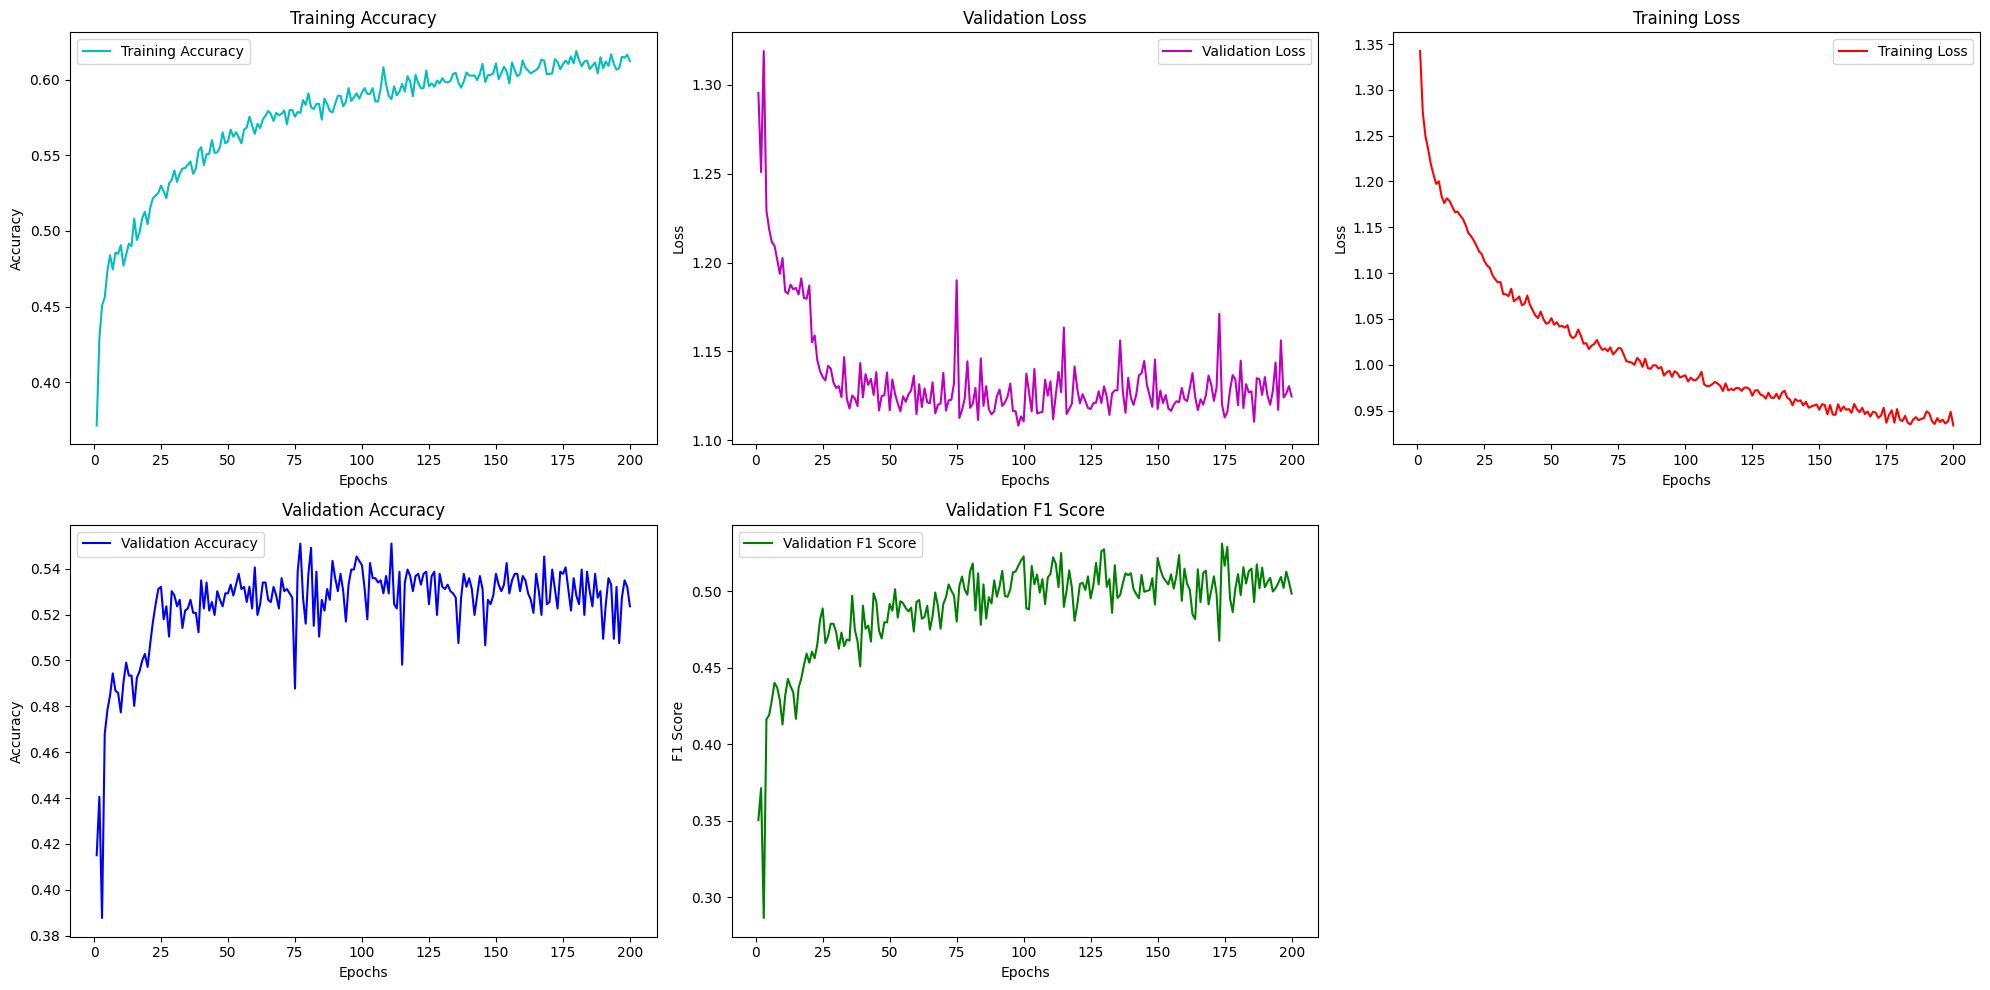

In [9]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pickle as pkl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# 数据集和词汇表路径
data_path = './data0924.txt'  # 数据集
vocab_path = './vocab.pkl'  # 词表

# 加载预训练的词嵌入
embedding_pretrained = torch.tensor(
    np.load('./embedding_Tencent.npz')["embeddings"].astype('float32')
)

# 数据加载和处理函数
def get_data(pad_size=512):
    tokenizer = lambda x: [y for y in x]  # 字级别分词器
    vocab = pkl.load(open(vocab_path, 'rb'))
    print(f"Vocab size: {len(vocab)}")

    train, dev, test = load_dataset(data_path, pad_size, tokenizer, vocab)
    return vocab, train, dev, test


def load_dataset(path, pad_size, tokenizer, vocab):
    '''
    将路径文本文件分词并转为三元结果返回
    :param path: 文件路径
    :param pad_size: 每个序列的大小
    :param tokenizer: 分词函数
    :param vocab: 词汇表
    :return: 三个数据集：训练集、验证集和测试集
    '''
    contents = []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:  # 忽略解码错误
        for line in tqdm(f):
            lin = line.strip()
            if not lin:
                continue
            label, content = lin.split('\t####\t')
            words_line = []
            token = tokenizer(content)
            seq_len = len(token)
            if pad_size:
                if len(token) < pad_size:
                    token.extend([vocab.get("<PAD>")] * (pad_size - len(token)))
                else:
                    token = token[:pad_size]
                    seq_len = pad_size
            for word in token:
                words_line.append(vocab.get(word, vocab.get("<UNK>")))
            contents.append((words_line, int(label)))

    train, X_t = train_test_split(contents, test_size=0.4, random_state=42)
    dev, test = train_test_split(X_t, test_size=0.5, random_state=42)
    return train, dev, test


# 数据集类
class TextDataset(Dataset):
    def __init__(self, data):
        # 直接保持数据在CPU上，减少显存占用
        self.x = torch.LongTensor([x[0] for x in data])
        self.y = torch.LongTensor([x[1] for x in data])

    def __getitem__(self, index):
        text = self.x[index]
        label = self.y[index]
        return text, label

    def __len__(self):
        return len(self.x)


# 模块化卷积块
class Block(nn.Module):
    def __init__(self, kernel_s, embedding_num, max_len, hidden_num):
        super().__init__()
        self.cnn = nn.Conv2d(in_channels=1, out_channels=hidden_num, kernel_size=(kernel_s, embedding_num))
        self.batch_norm = nn.BatchNorm2d(hidden_num)
        self.act = nn.ReLU()
        # 使用自适应泽化
        self.mxp = nn.AdaptiveMaxPool1d(1)

    def forward(self, batch_emb):
        c = self.cnn(batch_emb)
        c = self.batch_norm(c)
        a = self.act(c)
        a = a.squeeze(dim=-1)
        m = self.mxp(a)
        m = m.squeeze(dim=-1)
        return m


# TextCNN 模型定义
class TextCNNModel(nn.Module):
    def __init__(self, emb_matrix, max_len, class_num, hidden_num):
        super().__init__()
        self.emb_num = emb_matrix.weight.shape[1]
        self.block1 = Block(2, self.emb_num, max_len, hidden_num)
        self.block2 = Block(3, self.emb_num, max_len, hidden_num)
        self.block3 = Block(4, self.emb_num, max_len, hidden_num)
        self.block4 = Block(5, self.emb_num, max_len, hidden_num)
        self.emb_matrix = emb_matrix
        self.classifier = nn.Linear(hidden_num * 4, class_num)
        self.loss_fun = nn.CrossEntropyLoss()

    def forward(self, batch_idx, batch_label=None):
        batch_emb = self.emb_matrix(batch_idx)
        batch_emb = batch_emb.unsqueeze(1)  # 添加通道维度
        b1_result = self.block1(batch_emb)
        b2_result = self.block2(batch_emb)
        b3_result = self.block3(batch_emb)
        b4_result = self.block4(batch_emb)
        feature = torch.cat([b1_result, b2_result, b3_result, b4_result], dim=1)
        pre = self.classifier(feature)
        if batch_label is not None:
            loss = self.loss_fun(pre, batch_label)
            return loss, pre
        else:
            return pre


# 主程序
if __name__ == "__main__":
    # 假设训练数据和模型参数已知
    pad_size = 512
    class_num = 4  # 假设有 4 个分类
    hidden_num = 2
    batch_size = 16  # 减小 batch size 以减少显存占用
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 1. 获取数据集
    vocab, train_data, dev_data, test_data = get_data(pad_size)

    # 2. 构建 DataLoader
    train_dataset = TextDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    dev_dataset = TextDataset(dev_data)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # 3. 初始化模型
    emb_matrix = nn.Embedding(len(vocab), embedding_pretrained.shape[1])
    emb_matrix.weight.data.copy_(embedding_pretrained)
    emb_matrix.weight.requires_grad = False
    model = TextCNNModel(emb_matrix, pad_size, class_num, hidden_num).to(device)

    # 4. 定义优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 5. 训练模型并记录指标
    train_losses = []
    train_accuracies = []
    dev_losses = []
    dev_accuracies = []
    dev_f1_scores = []

    for epoch in range(200):
        total_loss = 0.0
        total_dev_loss = 0.0
        correct_train_preds = 0
        total_train_samples = 0
        model.train()
        for texts, labels in train_loader:
            optimizer.zero_grad()
            texts, labels = texts.to(device), labels.to(device)  # 确保数据在正确的设备上
            loss, outputs = model(texts, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=-1)
            correct_preds = (preds == labels).sum().item()
            correct_train_preds += correct_preds
            total_train_samples += len(labels)

        avg_loss = total_loss / len(train_loader)
        avg_train_acc = correct_train_preds / total_train_samples
        train_losses.append(avg_loss)
        train_accuracies.append(avg_train_acc)

        # 验证模型
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for texts, labels in dev_loader:
                texts, labels = texts.to(device), labels.to(device)  # 确保数据在正确的设备上
                loss, outputs = model(texts, labels)
                total_dev_loss += loss.item()
                preds = torch.argmax(outputs, dim=-1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_dev_loss = total_dev_loss / len(dev_loader)
        dev_losses.append(avg_dev_loss)
        dev_accuracies.append(acc)
        dev_f1_scores.append(f1)

        print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Train Accuracy: {avg_train_acc}, Dev Accuracy: {acc}, Dev F1 Score: {f1}")

    # 绘制图像
    epochs = range(1, 201)
    plt.figure(figsize=(20, 10))

    # Training Accuracy 图像
    plt.subplot(2, 3, 1)
    plt.plot(epochs, train_accuracies, 'c', label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    # Validation Loss 图像
    plt.subplot(2, 3, 2)
    plt.plot(epochs, dev_losses, 'm', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()

    # Training Loss 图像
    plt.subplot(2, 3, 3)
    plt.plot(epochs, train_losses, 'r', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Validation Accuracy 图像
    plt.subplot(2, 3, 4)
    plt.plot(epochs, dev_accuracies, 'b', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # F1-Score 图像
    plt.subplot(2, 3, 5)
    plt.plot(epochs, dev_f1_scores, 'g', label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


Vocab size: 4762


5300it [00:00, 12551.88it/s]
/environment/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1, Loss: 1.36809701176744, Train Accuracy: 0.3323899371069182, Dev Accuracy: 0.3339622641509434, Dev F1 Score: 0.1675728440955832


/environment/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2, Loss: 1.3563146669061938, Train Accuracy: 0.3339622641509434, Dev Accuracy: 0.3339622641509434, Dev F1 Score: 0.16885130080625052


/environment/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3, Loss: 1.3446394864039206, Train Accuracy: 0.3393081761006289, Dev Accuracy: 0.3330188679245283, Dev F1 Score: 0.16686295717662142


/environment/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4, Loss: 1.3359160956425882, Train Accuracy: 0.34685534591194966, Dev Accuracy: 0.3462264150943396, Dev F1 Score: 0.20472024564811192


/environment/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5, Loss: 1.3074771938611514, Train Accuracy: 0.38144654088050317, Dev Accuracy: 0.4386792452830189, Dev F1 Score: 0.40131856106042896


/environment/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6, Loss: 1.2716472094981515, Train Accuracy: 0.4050314465408805, Dev Accuracy: 0.4377358490566038, Dev F1 Score: 0.40201334388367055


/environment/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7, Loss: 1.2562274663292583, Train Accuracy: 0.4226415094339623, Dev Accuracy: 0.4320754716981132, Dev F1 Score: 0.3926156812291865


/environment/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8, Loss: 1.2390245064419119, Train Accuracy: 0.4380503144654088, Dev Accuracy: 0.44150943396226416, Dev F1 Score: 0.40095743916902676


/environment/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9, Loss: 1.2276269470027943, Train Accuracy: 0.44559748427672957, Dev Accuracy: 0.45849056603773586, Dev F1 Score: 0.39249405624431577
Epoch 10, Loss: 1.2293761375561432, Train Accuracy: 0.4468553459119497, Dev Accuracy: 0.44716981132075473, Dev F1 Score: 0.40795891139895385
Epoch 11, Loss: 1.217228062188805, Train Accuracy: 0.46163522012578617, Dev Accuracy: 0.4556603773584906, Dev F1 Score: 0.4147448476725666


/environment/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12, Loss: 1.2101624617025482, Train Accuracy: 0.45628930817610064, Dev Accuracy: 0.4650943396226415, Dev F1 Score: 0.41271186395143816


/environment/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13, Loss: 1.2033110087241359, Train Accuracy: 0.46949685534591196, Dev Accuracy: 0.4679245283018868, Dev F1 Score: 0.41510666440197325
Epoch 14, Loss: 1.1949058786109463, Train Accuracy: 0.4679245283018868, Dev Accuracy: 0.46320754716981133, Dev F1 Score: 0.41150153215768914
Epoch 15, Loss: 1.187678373638709, Train Accuracy: 0.47861635220125787, Dev Accuracy: 0.47452830188679246, Dev F1 Score: 0.4175160461371717
Epoch 16, Loss: 1.1890146897066778, Train Accuracy: 0.48238993710691824, Dev Accuracy: 0.4509433962264151, Dev F1 Score: 0.41002688373945634
Epoch 17, Loss: 1.1782840723967432, Train Accuracy: 0.4962264150943396, Dev Accuracy: 0.4688679245283019, Dev F1 Score: 0.43067429431371473
Epoch 18, Loss: 1.173496233758016, Train Accuracy: 0.49559748427672956, Dev Accuracy: 0.4707547169811321, Dev F1 Score: 0.42727427234724363
Epoch 19, Loss: 1.1675021894014062, Train Accuracy: 0.4959119496855346, Dev Accuracy: 0.44716981132075473, Dev F1 Score: 0.4184371973854591
Epoch 20, Loss: 1

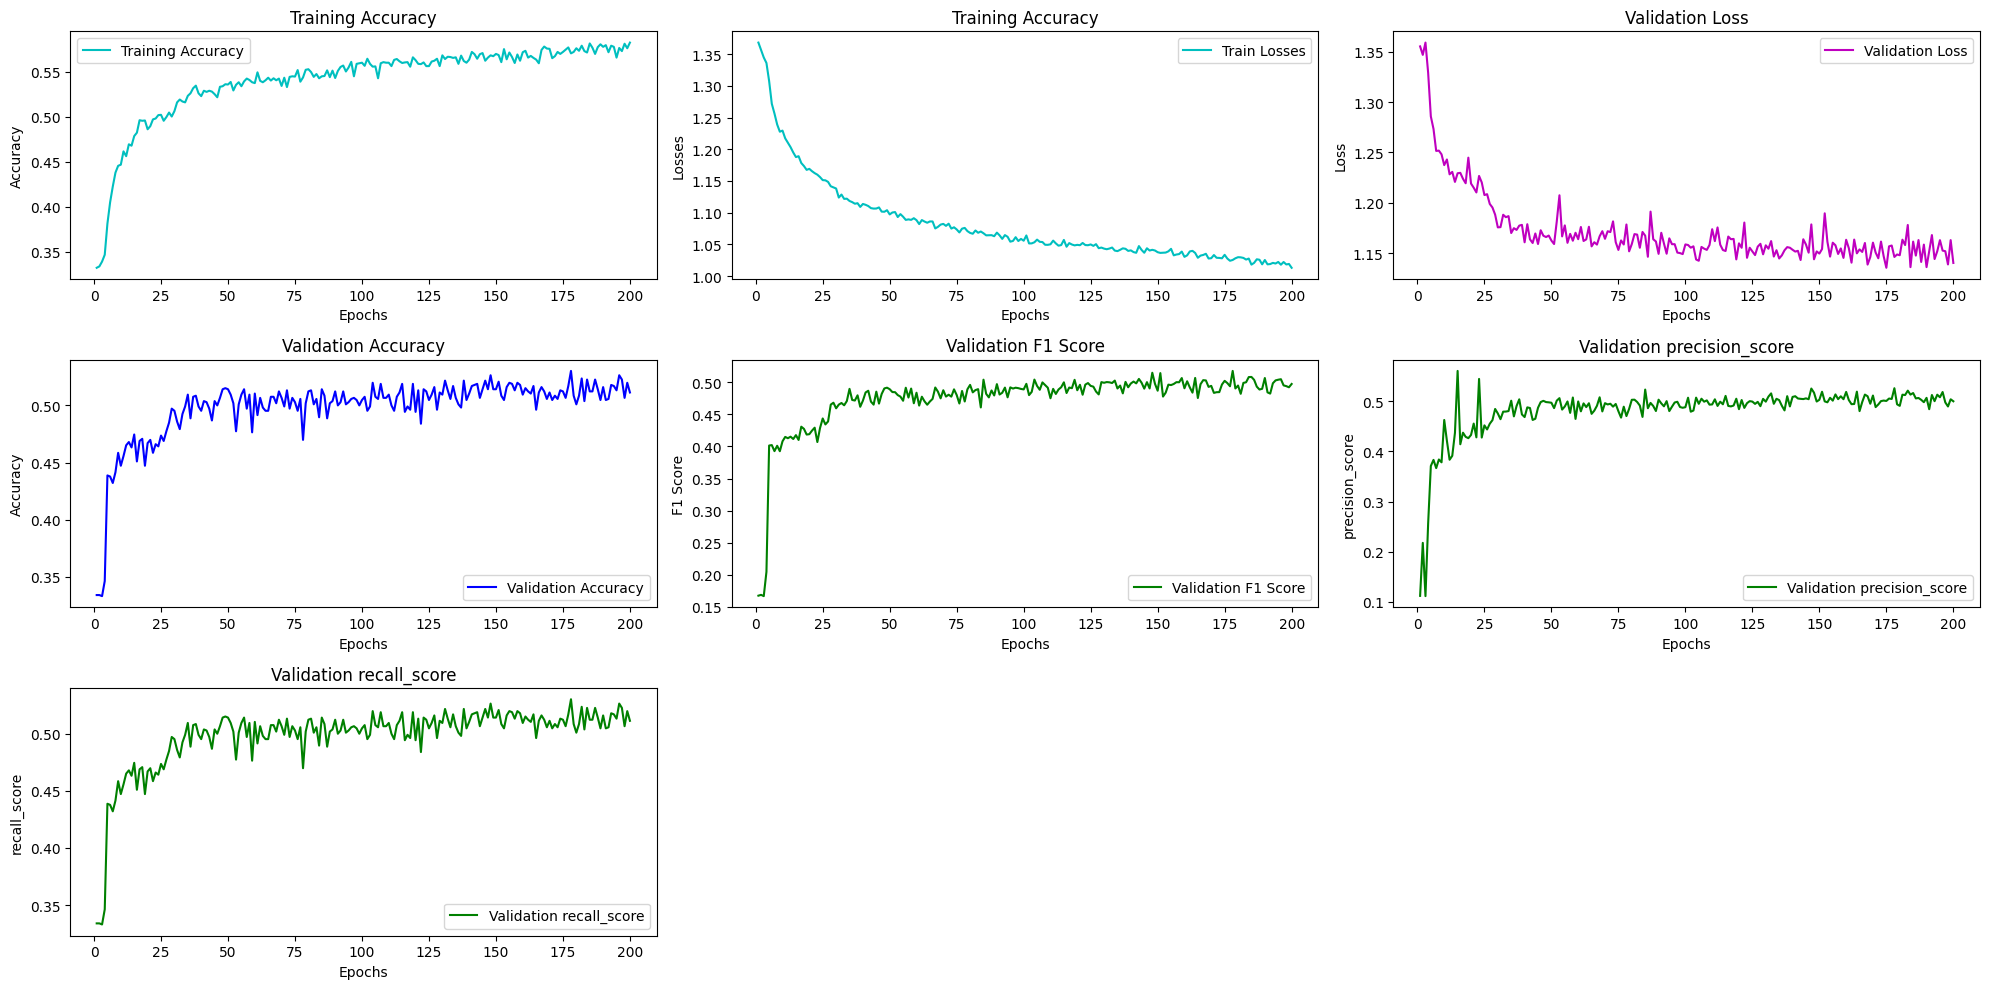

<Figure size 640x480 with 0 Axes>

In [53]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pickle as pkl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# 数据集和词汇表路径
data_path = './data0924.txt'  # 数据集
vocab_path = './vocab.pkl'  # 词表

# 加载预训练的词嵌入
embedding_pretrained = torch.tensor(
    np.load('./embedding_Tencent.npz')["embeddings"].astype('float32')
)

train_losses = []
    train_accuracies = []
    dev_losses = []
    dev_accuracies = []
    dev_f1_scores = []
    dev_precisions = []
    dev_recalls = []
# 数据加载和处理函数
def get_data(pad_size=512):
    tokenizer = lambda x: [y for y in x]  # 字级别分词器
    vocab = pkl.load(open(vocab_path, 'rb'))
    print(f"Vocab size: {len(vocab)}")

    train, dev, test = load_dataset(data_path, pad_size, tokenizer, vocab)
    return vocab, train, dev, test


def load_dataset(path, pad_size, tokenizer, vocab):
    '''
    将路径文本文件分词并转为三元结果返回
    :param path: 文件路径
    :param pad_size: 每个序列的大小
    :param tokenizer: 分词函数
    :param vocab: 词汇表
    :return: 三个数据集：训练集、验证集和测试集
    '''
    contents = []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:  # 忽略解码错误
        for line in tqdm(f):
            lin = line.strip()
            if not lin:
                continue
            label, content = lin.split('\t####\t')
            words_line = []
            token = tokenizer(content)
            seq_len = len(token)
            if pad_size:
                if len(token) < pad_size:
                    token.extend([vocab.get("<PAD>")] * (pad_size - len(token)))
                else:
                    token = token[:pad_size]
                    seq_len = pad_size
            for word in token:
                words_line.append(vocab.get(word, vocab.get("<UNK>")))
            contents.append((words_line, int(label)))

    train, X_t = train_test_split(contents, test_size=0.4, random_state=42)
    dev, test = train_test_split(X_t, test_size=0.5, random_state=42)
    return train, dev, test


# 数据集类
class TextDataset(Dataset):
    def __init__(self, data):
        # 直接保持数据在CPU上，减少显存占用
        self.x = torch.LongTensor([x[0] for x in data])
        self.y = torch.LongTensor([x[1] for x in data])

    def __getitem__(self, index):
        text = self.x[index]
        label = self.y[index]
        return text, label

    def __len__(self):
        return len(self.x)


# 模块化卷积块
class Block(nn.Module):
    def __init__(self, kernel_s, embedding_num, max_len, hidden_num):
        super().__init__()
        self.cnn = nn.Conv2d(in_channels=1, out_channels=hidden_num, kernel_size=(kernel_s, embedding_num))
        self.batch_norm = nn.BatchNorm2d(hidden_num)
        self.act = nn.ReLU()
        # 使用自适应泽化
        self.mxp = nn.AdaptiveMaxPool1d(1)

    def forward(self, batch_emb):
        c = self.cnn(batch_emb)
        c = self.batch_norm(c)
        a = self.act(c)
        a = a.squeeze(dim=-1)
        m = self.mxp(a)
        m = m.squeeze(dim=-1)
        return m


# TextCNN 模型定义
class TextCNNModel(nn.Module):
    def __init__(self, emb_matrix, max_len, class_num, hidden_num):
        super().__init__()
        self.emb_num = emb_matrix.weight.shape[1]
        self.block1 = Block(2, self.emb_num, max_len, hidden_num)
        self.block2 = Block(3, self.emb_num, max_len, hidden_num)
        self.block3 = Block(4, self.emb_num, max_len, hidden_num)
        self.block4 = Block(5, self.emb_num, max_len, hidden_num)
        self.emb_matrix = emb_matrix
        self.classifier = nn.Linear(hidden_num * 4, class_num)
        self.loss_fun = nn.CrossEntropyLoss()

    def forward(self, batch_idx, batch_label=None):
        batch_emb = self.emb_matrix(batch_idx)
        batch_emb = batch_emb.unsqueeze(1)  # 添加通道维度
        b1_result = self.block1(batch_emb)
        b2_result = self.block2(batch_emb)
        b3_result = self.block3(batch_emb)
        b4_result = self.block4(batch_emb)
        feature = torch.cat([b1_result, b2_result, b3_result, b4_result], dim=1)
        pre = self.classifier(feature)
        if batch_label is not None:
            loss = self.loss_fun(pre, batch_label)
            return loss, pre
        else:
            return pre


# 主程序
if __name__ == "__main__":
    # 假设训练数据和模型参数已知
    pad_size = 512
    class_num = 4  # 假设有 4 个分类
    hidden_num = 2
    batch_size = 16  # 减小 batch size 以减少显存占用
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 1. 获取数据集
    vocab, train_data, dev_data, test_data = get_data(pad_size)

    # 2. 构建 DataLoader
    train_dataset = TextDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    dev_dataset = TextDataset(dev_data)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # 3. 初始化模型
    emb_matrix = nn.Embedding(len(vocab), embedding_pretrained.shape[1])
    emb_matrix.weight.data.copy_(embedding_pretrained)
    emb_matrix.weight.requires_grad = False
    model = TextCNNModel(emb_matrix, pad_size, class_num, hidden_num).to(device)

    # 4. 定义优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 5. 训练模型并记录指标
    

    for epoch in range(200):
        total_loss = 0.0
        total_dev_loss = 0.0
        correct_train_preds = 0
        total_train_samples = 0
        model.train()
        for texts, labels in train_loader:
            optimizer.zero_grad()
            texts, labels = texts.to(device), labels.to(device)  # 确保数据在正确的设备上
            loss, outputs = model(texts, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=-1)
            correct_preds = (preds == labels).sum().item()
            correct_train_preds += correct_preds
            total_train_samples += len(labels)

        avg_loss = total_loss / len(train_loader)
        avg_train_acc = correct_train_preds / total_train_samples
        train_losses.append(avg_loss)
        train_accuracies.append(avg_train_acc)

        # 验证模型
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for texts, labels in dev_loader:
                texts, labels = texts.to(device), labels.to(device)  # 确保数据在正确的设备上
                loss, outputs = model(texts, labels)
                total_dev_loss += loss.item()
                preds = torch.argmax(outputs, dim=-1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        avg_dev_loss = total_dev_loss / len(dev_loader)
        dev_losses.append(avg_dev_loss)
        dev_accuracies.append(acc)
        dev_f1_scores.append(f1)
        dev_precisions.append(precision)  
        dev_recalls.append(recall)  

        print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Train Accuracy: {avg_train_acc}, Dev Accuracy: {acc}, Dev F1 Score: {f1}")

    # 绘制图像
    epochs = range(1, 201)
    plt.figure(figsize=(20, 10))

    # Training Accuracy 图像
    plt.subplot(3, 3, 1)
    plt.plot(epochs, train_accuracies, 'c', label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()
    
    # Training Losses 图像
    plt.subplot(3, 3, 2)
    plt.plot(epochs, train_losses, 'c', label='Train Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title('Training Accuracy')
    plt.legend()

    # Validation Loss 图像
    plt.subplot(3, 3, 3)
    plt.plot(epochs, dev_losses, 'm', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()

    # Validation Accuracy 图像
    plt.subplot(3, 3, 4)
    plt.plot(epochs, dev_accuracies, 'b', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # F1-Score 图像
    plt.subplot(3, 3, 5)
    plt.plot(epochs, dev_f1_scores, 'g', label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score')
    plt.legend()

    # precision_score 图像
    plt.subplot(3, 3, 6)
    plt.plot(epochs, dev_precisions, 'g', label='Validation precision_score')
    plt.xlabel('Epochs')
    plt.ylabel('precision_score')
    plt.title('Validation precision_score')
    plt.legend()

    # recall_score 图像
    plt.subplot(3, 3, 7)
    plt.plot(epochs, dev_recalls, 'g', label='Validation recall_score')
    plt.xlabel('Epochs')
    plt.ylabel('recall_score')
    plt.title('Validation recall_score')
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()
    plt.savefig('1234.pdf')

In [48]:

plt.savefig('training_validation_metrics.pdf')  # 保存为 PDF 文件
plt.show()

# 创建一个 DataFrame 来保存参数
data = {
    'Epochs': epochs,
    'Train Accuracy': train_accuracies,
    'Train Losses': train_losses,
    'Validation Loss': dev_losses,
    'Validation Accuracy': dev_accuracies,
    'Validation F1 Score': dev_f1_scores,
    'Validation Precision': dev_precisions,
    'Validation Recall': dev_recalls,
}

df = pd.DataFrame(data)

# 保存 DataFrame 为 CSV 文件
df.to_csv('training_validation_metrics.csv', index=False)

<Figure size 640x480 with 0 Axes>

In [51]:
# 绘制图像
    epochs = range(1, 201)
    plt.figure(figsize=(20, 10))

    # Training Accuracy 图像
    plt.subplot(3, 3, 1)
    plt.plot(epochs, train_accuracies, 'c', label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()
    
    # Training Losses 图像
    plt.subplot(3, 3, 2)
    plt.plot(epochs, train_losses, 'c', label='Train Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title('Training Accuracy')
    plt.legend()

    # Validation Loss 图像
    plt.subplot(3, 3, 3)
    plt.plot(epochs, dev_losses, 'm', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()

    # Validation Accuracy 图像
    plt.subplot(3, 3, 4)
    plt.plot(epochs, dev_accuracies, 'b', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # F1-Score 图像
    plt.subplot(3, 3, 5)
    plt.plot(epochs, dev_f1_scores, 'g', label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score')
    plt.legend()

    # precision_score 图像
    plt.subplot(3, 3, 6)
    plt.plot(epochs, dev_precisions, 'g', label='Validation precision_score')
    plt.xlabel('Epochs')
    plt.ylabel('precision_score')
    plt.title('Validation precision_score')
    plt.legend()

    # recall_score 图像
    plt.subplot(3, 3, 7)
    plt.plot(epochs, dev_recalls, 'g', label='Validation recall_score')
    plt.xlabel('Epochs')
    plt.ylabel('recall_score')
    plt.title('Validation recall_score')
    plt.legend()

    plt.tight_layout()
    plt.show()

plt.savefig('1234.pdf')  # 保存为 PDF 文件
plt.show()

IndentationError: unexpected indent (1216333593.py, line 2)

In [50]:
plt.show()

In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pickle as pkl
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# 数据集和词汇表路径
data_path = './data0924.txt'  # 数据集
vocab_path = './vocab.pkl'  # 词表

# 加载预训练的词嵌入
embedding_pretrained = torch.tensor(
    np.load('./embedding_Tencent.npz')["embeddings"].astype('float32')
)

# 数据加载和处理函数
def get_data(pad_size=512):
    tokenizer = lambda x: [y for y in x]  # 字级别分词器
    vocab = pkl.load(open(vocab_path, 'rb'))
    contents = load_dataset(data_path, pad_size, tokenizer, vocab)
    return vocab, contents

def load_dataset(path, pad_size, tokenizer, vocab):
    contents = []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in tqdm(f):
            lin = line.strip()
            if not lin:
                continue
            label, content = lin.split('\t####\t')
            words_line = []
            token = tokenizer(content)
            seq_len = len(token)
            if pad_size:
                if len(token) < pad_size:
                    token.extend([vocab.get("<PAD>")] * (pad_size - len(token)))
                else:
                    token = token[:pad_size]
                    seq_len = pad_size
            for word in token:
                words_line.append(vocab.get(word, vocab.get("<UNK>")))
            contents.append((words_line, int(label)))
    return contents

# 数据集类
class TextDataset(Dataset):
    def __init__(self, data):
        self.x = torch.LongTensor([x[0] for x in data])
        self.y = torch.LongTensor([x[1] for x in data])

    def __getitem__(self, index):
        text = self.x[index]
        label = self.y[index]
        return text, label

    def __len__(self):
        return len(self.x)

# 模块化卷积块
class Block(nn.Module):
    def __init__(self, kernel_s, embedding_num, max_len, hidden_num):
        super().__init__()
        self.cnn = nn.Conv2d(in_channels=1, out_channels=hidden_num, kernel_size=(kernel_s, embedding_num))
        self.batch_norm = nn.BatchNorm2d(hidden_num)
        self.act = nn.ReLU()
        self.mxp = nn.AdaptiveMaxPool1d(1)

    def forward(self, batch_emb):
        c = self.cnn(batch_emb)
        c = self.batch_norm(c)
        a = self.act(c)
        a = a.squeeze(dim=-1)
        m = self.mxp(a)
        m = m.squeeze(dim=-1)
        return m

# TextCNN 模型定义
class TextCNNModel(nn.Module):
    def __init__(self, emb_matrix, max_len, class_num, hidden_num):
        super().__init__()
        self.emb_num = emb_matrix.weight.shape[1]
        self.block1 = Block(2, self.emb_num, max_len, hidden_num)
        self.block2 = Block(3, self.emb_num, max_len, hidden_num)
        self.block3 = Block(4, self.emb_num, max_len, hidden_num)
        self.block4 = Block(5, self.emb_num, max_len, hidden_num)
        self.emb_matrix = emb_matrix
        self.classifier = nn.Linear(hidden_num * 4, class_num)
        self.loss_fun = nn.CrossEntropyLoss()

    def forward(self, batch_idx, batch_label=None):
        batch_emb = self.emb_matrix(batch_idx)
        batch_emb = batch_emb.unsqueeze(1)  # 添加通道维度
        b1_result = self.block1(batch_emb)
        b2_result = self.block2(batch_emb)
        b3_result = self.block3(batch_emb)
        b4_result = self.block4(batch_emb)
        feature = torch.cat([b1_result, b2_result, b3_result, b4_result], dim=1)
        pre = self.classifier(feature)
        if batch_label is not None:
            loss = self.loss_fun(pre, batch_label)
            return loss, pre
        else:
            return pre

# 主程序
if __name__ == "__main__":
    pad_size = 512
    class_num = 4  # 假设有 4 个分类
    hidden_num = 2
    batch_size = 16
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 获取数据集
    vocab, contents = get_data(pad_size)

    # 定义KFold对象
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # 初始化存储每折的结果
    fold_dev_accuracies = []
    fold_dev_f1_scores = []
    fold_dev_recalls = []
    fold_dev_losses = []

    # 打开文件保存结果
    with open("textcnn.txt", "w") as f:
        f.write("Fold\tLoss\tAccuracy\tF1 Score\tRecall\n")

        # 遍历每一折
        for fold, (train_index, dev_index) in enumerate(kf.split(contents)):
            # 分割数据
            train_data = [contents[i] for i in train_index]
            dev_data = [contents[i] for i in dev_index]

            # 构建 DataLoader
            train_dataset = TextDataset(train_data)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
            dev_dataset = TextDataset(dev_data)
            dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

            # 初始化模型
            emb_matrix = nn.Embedding(len(vocab), embedding_pretrained.shape[1])
            emb_matrix.weight.data.copy_(embedding_pretrained)
            emb_matrix.weight.requires_grad = False
            model = TextCNNModel(emb_matrix, pad_size, class_num, hidden_num).to(device)

            # 定义优化器
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

            # 训练模型
            for epoch in range(20):  # 每折训练 20 个 epoch
                model.train()
                for texts, labels in train_loader:
                    optimizer.zero_grad()
                    texts, labels = texts.to(device), labels.to(device)
                    loss, outputs = model(texts, labels)
                    loss.backward()
                    optimizer.step()

            # 验证模型
            model.eval()
            all_preds = []
            all_labels = []
            total_dev_loss = 0
            with torch.no_grad():
                for texts, labels in dev_loader:
                    texts, labels = texts.to(device), labels.to(device)
                    loss, outputs = model(texts, labels)
                    total_dev_loss += loss.item()
                    preds = torch.argmax(outputs, dim=-1)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            # 计算指标
            avg_dev_loss = total_dev_loss / len(dev_loader)
            acc = accuracy_score(all_labels, all_preds)
            f1 = f1_score(all_labels, all_preds, average='weighted')
            recall = recall_score(all_labels, all_preds, average='weighted')

            # 记录每折的指标
            fold_dev_losses.append(avg_dev_loss)
            fold_dev_accuracies.append(acc)
            fold_dev_f1_scores.append(f1)
            fold_dev_recalls.append(recall)

            # 将结果写入文件
            f.write(f"{fold+1}\t{avg_dev_loss:.4f}\t{acc:.4f}\t{f1:.4f}\t{recall:.4f}\n")
            print(f"Fold {fold+1}, Loss: {avg_dev_loss:.4f}, Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}")

        # 计算并写入平均结果
        f.write("\nAverage\n")
        f.write(f"Loss: {np.mean(fold_dev_losses):.4f}\t"
                f"Accuracy: {np.mean(fold_dev_accuracies):.4f}\t"
                f"F1 Score: {np.mean(fold_dev_f1_scores):.4f}\t"
                f"Recall: {np.mean(fold_dev_recalls):.4f}\n")

    print("Results saved to textcnn.txt.")


5300it [00:00, 9547.87it/s]


Fold 1, Loss: 1.1733, Accuracy: 0.4906, F1 Score: 0.4494, Recall: 0.4906
Fold 2, Loss: 1.1416, Accuracy: 0.4962, F1 Score: 0.4260, Recall: 0.4962
Fold 3, Loss: 1.1598, Accuracy: 0.5151, F1 Score: 0.4976, Recall: 0.5151
Fold 4, Loss: 1.1940, Accuracy: 0.4585, F1 Score: 0.4093, Recall: 0.4585
Fold 5, Loss: 1.1654, Accuracy: 0.4962, F1 Score: 0.4579, Recall: 0.4962
Fold 6, Loss: 1.0893, Accuracy: 0.5170, F1 Score: 0.4869, Recall: 0.5170
Fold 7, Loss: 1.0745, Accuracy: 0.5170, F1 Score: 0.4833, Recall: 0.5170
Fold 8, Loss: 1.1464, Accuracy: 0.4906, F1 Score: 0.4265, Recall: 0.4906
Fold 9, Loss: 1.0701, Accuracy: 0.5415, F1 Score: 0.5126, Recall: 0.5415
Fold 10, Loss: 1.1817, Accuracy: 0.4849, F1 Score: 0.4632, Recall: 0.4849
Results saved to textcnn.txt.


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pickle as pkl
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# 数据集和词汇表路径
data_path = './data0924.txt'  # 数据集
vocab_path = './vocab.pkl'  # 词表

# 加载预训练的词嵌入
embedding_pretrained = torch.tensor(
    np.load('./embedding_Tencent.npz')["embeddings"].astype('float32')
)

# 数据加载和处理函数
def get_data(pad_size=512):
    tokenizer = lambda x: [y for y in x]  # 字级别分词器
    vocab = pkl.load(open(vocab_path, 'rb'))
    contents = load_dataset(data_path, pad_size, tokenizer, vocab)
    return vocab, contents

def load_dataset(path, pad_size, tokenizer, vocab):
    contents = []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in tqdm(f):
            lin = line.strip()
            if not lin:
                continue
            label, content = lin.split('\t####\t')
            words_line = []
            token = tokenizer(content)
            seq_len = len(token)
            if pad_size:
                if len(token) < pad_size:
                    token.extend([vocab.get("<PAD>")] * (pad_size - len(token)))
                else:
                    token = token[:pad_size]
                    seq_len = pad_size
            for word in token:
                words_line.append(vocab.get(word, vocab.get("<UNK>")))
            contents.append((words_line, int(label)))
    return contents

# 数据集类
class TextDataset(Dataset):
    def __init__(self, data):
        self.x = torch.LongTensor([x[0] for x in data])
        self.y = torch.LongTensor([x[1] for x in data])

    def __getitem__(self, index):
        text = self.x[index]
        label = self.y[index]
        return text, label

    def __len__(self):
        return len(self.x)

# 模块化卷积块
class Block(nn.Module):
    def __init__(self, kernel_s, embedding_num, max_len, hidden_num):
        super().__init__()
        self.cnn = nn.Conv2d(in_channels=1, out_channels=hidden_num, kernel_size=(kernel_s, embedding_num))
        self.batch_norm = nn.BatchNorm2d(hidden_num)
        self.act = nn.ReLU()
        self.mxp = nn.AdaptiveMaxPool1d(1)

    def forward(self, batch_emb):
        c = self.cnn(batch_emb)
        c = self.batch_norm(c)
        a = self.act(c)
        a = a.squeeze(dim=-1)
        m = self.mxp(a)
        m = m.squeeze(dim=-1)
        return m

# TextCNN 模型定义
class TextCNNModel(nn.Module):
    def __init__(self, emb_matrix, max_len, class_num, hidden_num):
        super().__init__()
        self.emb_num = emb_matrix.weight.shape[1]
        self.block1 = Block(2, self.emb_num, max_len, hidden_num)
        self.block2 = Block(3, self.emb_num, max_len, hidden_num)
        self.block3 = Block(4, self.emb_num, max_len, hidden_num)
        self.block4 = Block(5, self.emb_num, max_len, hidden_num)
        self.emb_matrix = emb_matrix
        self.classifier = nn.Linear(hidden_num * 4, class_num)
        self.loss_fun = nn.CrossEntropyLoss()

    def forward(self, batch_idx, batch_label=None):
        batch_emb = self.emb_matrix(batch_idx)
        batch_emb = batch_emb.unsqueeze(1)  # 添加通道维度
        b1_result = self.block1(batch_emb)
        b2_result = self.block2(batch_emb)
        b3_result = self.block3(batch_emb)
        b4_result = self.block4(batch_emb)
        feature = torch.cat([b1_result, b2_result, b3_result, b4_result], dim=1)
        pre = self.classifier(feature)
        if batch_label is not None:
            loss = self.loss_fun(pre, batch_label)
            return loss, pre
        else:
            return pre

# 主程序
if __name__ == "__main__":
    pad_size = 512
    class_num = 4  # 假设有 4 个分类
    hidden_num = 2
    batch_size = 16
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 获取数据集
    vocab, contents = get_data(pad_size)

    # 定义KFold对象
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # 打开文件保存结果
    with open("textcnn.txt", "w") as f:
        f.write("Fold\tEpoch\tTrain Loss\tTrain Acc\tVal Loss\tVal Acc\tPrecision\tRecall\tF1\n")

        # 遍历每一折
        for fold, (train_index, dev_index) in enumerate(kf.split(contents)):
            # 分割数据
            train_data = [contents[i] for i in train_index]
            dev_data = [contents[i] for i in dev_index]

            # 构建 DataLoader
            train_dataset = TextDataset(train_data)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
            dev_dataset = TextDataset(dev_data)
            dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

            # 初始化模型
            emb_matrix = nn.Embedding(len(vocab), embedding_pretrained.shape[1])
            emb_matrix.weight.data.copy_(embedding_pretrained)
            emb_matrix.weight.requires_grad = False
            model = TextCNNModel(emb_matrix, pad_size, class_num, hidden_num).to(device)

            # 定义优化器
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

            # 记录每折每个epoch的指标
            train_losses, train_accuracies = [], []
            val_losses, val_accuracies = [], []
            val_precisions, val_recalls, val_f1_scores = [], [], []

            # 训练模型
            for epoch in range(20):  # 每折训练 20 个 epoch
                model.train()
                total_train_loss, correct_train_preds, total_train_samples = 0, 0, 0
                for texts, labels in train_loader:
                    optimizer.zero_grad()
                    texts, labels = texts.to(device), labels.to(device)
                    loss, outputs = model(texts, labels)
                    loss.backward()
                    optimizer.step()

                    total_train_loss += loss.item()
                    preds = torch.argmax(outputs, dim=-1)
                    correct_train_preds += (preds == labels).sum().item()
                    total_train_samples += len(labels)

                # 计算训练指标
                avg_train_loss = total_train_loss / len(train_loader)
                train_acc = correct_train_preds / total_train_samples
                train_losses.append(avg_train_loss)
                train_accuracies.append(train_acc)

                # 验证模型
                model.eval()
                total_val_loss = 0
                all_preds, all_labels = [], []
                with torch.no_grad():
                    for texts, labels in dev_loader:
                        texts, labels = texts.to(device), labels.to(device)
                        loss, outputs = model(texts, labels)
                        total_val_loss += loss.item()
                        preds = torch.argmax(outputs, dim=-1)
                        all_preds.extend(preds.cpu().numpy())
                        all_labels.extend(labels.cpu().numpy())

                # 计算验证指标
                avg_val_loss = total_val_loss / len(dev_loader)
                val_acc = accuracy_score(all_labels, all_preds)
                precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
                recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
                f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

                val_losses.append(avg_val_loss)
                val_accuracies.append(val_acc)
                val_precisions.append(precision)
                val_recalls.append(recall)
                val_f1_scores.append(f1)

                # 写入每个epoch的结果
                f.write(f"{fold+1}\t{epoch+1}\t{avg_train_loss:.4f}\t{train_acc:.4f}\t"
                        f"{avg_val_loss:.4f}\t{val_acc:.4f}\t{precision:.4f}\t{recall:.4f}\t{f1:.4f}\n")

            # 计算并写入每折的平均指标
            f.write(f"{fold+1}\tAverage\t{np.mean(train_losses):.4f}\t{np.mean(train_accuracies):.4f}\t"
                    f"{np.mean(val_losses):.4f}\t{np.mean(val_accuracies):.4f}\t"
                    f"{np.mean(val_precisions):.4f}\t{np.mean(val_recalls):.4f}\t{np.mean(val_f1_scores):.4f}\n\n")

    print("Results saved to textcnn.txt.")


5300it [00:00, 9146.74it/s]


Results saved to textcnn.txt.
